In [22]:
import pandas as pd
import numpy as np
from numpy import *
import warnings
import multiprocessing
from matplotlib import pyplot
import gensim
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras import backend as K 

from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

In [2]:
# Set the number of threads TensorFlow should use
num_threads = multiprocessing.cpu_count()

# Set the number of intra and inter op parallelism threads
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

In [3]:
max_text_len=900
max_summary_len=100

In [4]:
post_pre = pd.read_csv ('../Dataset/Indonesian News Dataset Preprocessed.csv', sep=';')

In [5]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

post_pre['text'] = post_pre['text'].astype(str)
post_pre['summary'] = post_pre['summary'].astype(str)

In [6]:
post_pre.head()

,text,summary
0,jakarta anggota komisi vii dpr ri rofik hanan...,sostok _START_ anggota komisi vii dpr ri rofik...
1,jakarta presiden joko widodo atau jokowi meme...,sostok _START_ presiden joko widodo telah meme...
2,wakil ketua mpr ri dr hidayat nur wahid ma at...,sostok _START_ wakil ketua mpr ri dr hidayat n...
3,jakarta tim kedokteran dan kesehatan dokkes p...,sostok _START_ tim kedokteran dan kesehatan do...
4,ketua mpr ri sekaligus ketua umum ikatan moto...,sostok _START_ ketua mpr ri bambang soesatyo t...


In [7]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [8]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [9]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 59.93512417638115
Total Coverage of rare words: 1.226265582590004


In [10]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 39525


In [11]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [12]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 58.711142993782886
Total Coverage of rare words: 2.310523215900181


In [13]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 17268


We will now remove "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [14]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [15]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [16]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Size of vocabulary from the w2v model = 39525


2024-04-23 16:09:26.902837: E tensorflow/compiler/xla/stream_executor/rocm/rocm_driver.cc:302] failed call to hipInit: HIP_ERROR_InvalidDevice
2024-04-23 16:09:26.902855: I tensorflow/compiler/xla/stream_executor/rocm/rocm_diagnostics.cc:111] retrieving ROCM diagnostic information for host: chrylus-ubuntu
2024-04-23 16:09:26.902860: I tensorflow/compiler/xla/stream_executor/rocm/rocm_diagnostics.cc:118] hostname: chrylus-ubuntu
2024-04-23 16:09:26.902948: I tensorflow/compiler/xla/stream_executor/rocm/rocm_diagnostics.cc:141] librocm reported version is: NOT_FOUND: was unable to find librocm.so DSO loaded into this program
2024-04-23 16:09:26.902952: I tensorflow/compiler/xla/stream_executor/rocm/rocm_diagnostics.cc:145] kernel reported version is: UNIMPLEMENTED: kernel reported driver version not implemented
2024-04-23 16:09:26.916872: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:09:26.918527: I tensorflow/core/common_runtime/gpu_fusio

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 900)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 900, 200)             7905000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 900, 300),           601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

2024-04-23 16:09:27.162550: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:09:27.163211: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:09:27.164056: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:09:27.164467: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:09:27.172466: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:09:27.173022: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:09:27.173373: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


In [17]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

2024-04-23 16:09:27.190315: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:09:27.190838: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


In [23]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [24]:
# Training with a progress bar
history = model.fit([x_tr, y_tr[:,:-1]], 
                    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                    epochs=10,
                    batch_size=128,
                    validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]),
                    callbacks=[early_stopping])

# Save model, kalau mau load pake cell bawah
model.save('../Model/final_trained_model.h5')

Epoch 1/10


2024-04-23 16:12:42.424473: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:12:42.432277: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:12:42.439666: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:12:42.446391: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:12:42.452088: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:12:42.455386: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - ETA: 0s - loss: 4.8849

2024-04-23 16:32:53.194077: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:32:53.194618: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:32:53.194991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:32:53.200551: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:32:53.201112: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:32:53.205221: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:32:53.206022: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:32:53.206480: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:32:53.206972: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:32:53

197/197 [==============================] - 1252s 6s/step - loss: 4.8849 - val_loss: 4.5418
Epoch 2/10


2024-04-23 16:33:34.107786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:33:34.114148: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:33:34.114878: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:33:34.116071: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:33:34.117572: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:33:34.123422: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:33:34.126913: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - ETA: 0s - loss: 4.5435

2024-04-23 16:53:33.229934: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:53:33.232831: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 16:53:33.235534: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 1239s 6s/step - loss: 4.5435 - val_loss: 4.4917
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 4.5207

2024-04-23 17:14:16.853370: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 17:14:16.856427: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 17:14:16.858959: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 1244s 6s/step - loss: 4.5207 - val_loss: 4.4810
Epoch 4/10
197/197 [==============================] - ETA: 0s - loss: 4.5069

2024-04-23 17:34:57.067220: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 17:34:57.070149: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 17:34:57.072713: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 1240s 6s/step - loss: 4.5069 - val_loss: 4.4599
Epoch 5/10
197/197 [==============================] - ETA: 0s - loss: 4.4793

2024-04-23 17:55:38.201766: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 17:55:38.204751: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 17:55:38.207401: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 1241s 6s/step - loss: 4.4793 - val_loss: 4.4271
Epoch 6/10
197/197 [==============================] - ETA: 0s - loss: 4.4473

2024-04-23 18:16:19.013215: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 18:16:19.016098: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 18:16:19.018653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 1241s 6s/step - loss: 4.4473 - val_loss: 4.4046
Epoch 7/10
197/197 [==============================] - ETA: 0s - loss: 4.4186

2024-04-23 18:36:59.380118: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 18:36:59.383089: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 18:36:59.385741: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 1240s 6s/step - loss: 4.4186 - val_loss: 4.3772
Epoch 8/10
197/197 [==============================] - ETA: 0s - loss: 4.3934

2024-04-23 18:57:41.518845: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 18:57:41.521712: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 18:57:41.524203: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 1242s 6s/step - loss: 4.3934 - val_loss: 4.3675
Epoch 9/10
197/197 [==============================] - ETA: 0s - loss: 4.3690

2024-04-23 19:18:23.504023: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:18:23.507061: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:18:23.509661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 1242s 6s/step - loss: 4.3690 - val_loss: 4.3255
Epoch 10/10
197/197 [==============================] - ETA: 0s - loss: 4.3425

2024-04-23 19:39:04.126720: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:39:04.129605: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:39:04.132186: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 1241s 6s/step - loss: 4.3425 - val_loss: 4.2951


In [25]:
# Path to the checkpoint weights file
checkpoint_path = "../Model/final_trained_model.h5"

# Load the model
loaded_model = load_model(checkpoint_path)

2024-04-23 19:45:32.228920: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:45:32.229808: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:45:32.230467: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:45:32.230855: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:45:32.234772: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:45:32.239388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:45:32.239836: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


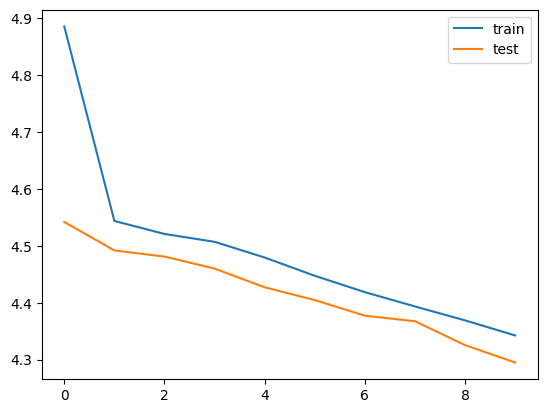

In [26]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [27]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [28]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**We are defining a function below which is the implementation of the inference process**

In [29]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [30]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**Run the model over the data to see the results**

In [32]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Your existing code here
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: singapura buruh migran indonesia bmi yang bekerja di singapura masita 33 divonis enam bulan penjara usai menggigit lengan bayi pelaku menggigit salah satu anak kembar yang seharusnya ia asuh dengan lembut dikutip dari channel news asia cna vonis itu jatuh pada hari ini selasa 4 4 2023 waktu setempat masita didakwa menganiaya bayi dengan sengaja sehingga menyebabkan rasa sakit yang tidak perlu masita sudah bekerja sejak 2021 tugas masita di keluarga tersebut ialah merawat bayi kembar serta mengurusi pekerjaan rumah tangga aksi gigit lengan itu berawal saat majikan masita meninggalkan rumah untuk menjemput anak sulungnya dari tk pada 26 mei 2022 sekitar pukul 17 00 waktu setempat sementara masita ditinggal di rumah bersama bayi kembarnya yang saat itu berusia 14 bulan masita mencoba menidurkan mereka tetapi menjadi frustrasi dengan salah satu bayi setelah sekitar setengah jam enggan tidur lalu masita merasa korban menunda tugasnya untuk memasak makan malam sekitar pukul 18 30 dia

2024-04-23 19:55:11.940364: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:11.947300: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:11.952692: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:11.957245: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:11.961041: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:11.963508: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:12.245054: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.250225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.256102: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.260080: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.263234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.266643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.274822: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.279955: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.285785: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12

1/1 [==============================] - ETA: 0s

2024-04-23 19:55:12.447446: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.452831: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.456844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.459604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.462563: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.471078: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.476297: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.481969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.486322: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:12.658905: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.665482: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.671842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.675625: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.679346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.682436: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.690785: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.695636: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.700848: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:12.865869: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.870355: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.875769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.883529: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.887629: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.892135: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.906595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.911808: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12.917640: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:12

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:13.067457: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.070426: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.073320: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.082068: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.086982: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.092501: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.096273: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.099024: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.101833: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:13.274655: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.278119: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.280703: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.283547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.291503: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.295561: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.300567: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.304072: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.306680: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:13.477123: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.479943: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.487858: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.492225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.497411: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.500824: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.503422: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.506256: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.515062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia prancis makin mencekam kamis 23 3 2023 situasi dilaporkan sejumlah media bak medan perang ini terkait protes nasional di negara itu yang memasuki hari ke kelompok anarkis blok hitam menghancurkan jendela toko infrastruktur jalan dan mengobrak abrik restoran menteri dalam negeri gerald darmanin melaporkan 123 petugas polisi terluka sebanyak 80 orang ditangkap di seluruh negeri apa sebabnya hal ini tak lain akibat undang undang baru yang hendak disahkan presiden prancis emmanuel macron ia akan menaikkan usia pensiun dari 62 tahun menjadi 64 tahun kebijakan ini juga akan meningkatkan masa iuran yang diperlukan untuk pen

2024-04-23 19:55:13.678413: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.682788: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.688789: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.692706: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.695414: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.698230: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.708668: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.713790: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13.717386: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:13

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:14.005120: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.009145: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.014440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.017977: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.020528: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.023288: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.030651: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.034905: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.039644: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:14.205575: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.211773: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.215646: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.218731: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.221982: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.231732: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.236144: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.242411: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.245900: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:14.408634: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.412024: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.414662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.417493: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.426063: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.430725: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.436892: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.440404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.443164: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:14.610276: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.618966: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.623392: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.629396: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.632922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.635542: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.638403: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.646356: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.650488: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:14.812974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.820610: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.826109: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.831367: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.835193: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.837910: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.840745: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.849152: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14.853612: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:14

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:15.013934: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.019323: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.023103: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.025796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.028685: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.035930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.040244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.045279: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.048715: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:15.214978: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.218540: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.227590: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.234054: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.242377: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.255605: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.259233: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.263802: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.273824: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: seorang wanita asal yogyakarta diamankan polisi lantaran melakukan penipuan dengan modus bisa meloloskan masuk akademi polisi akpol adapun pelaku itu bernama warga kecamatan berbah kabupaten sleman yogyakarta kasubdit penmas humas polda lampung akbp rahmat hidayat mengatakan pelaku ditangkap setelah menipu korban fz warga lampung selatan pelaku diamankan saat berada di kediamannya di sleman yogyakarta pada senin 20 maret 2023 katanya jumat 24 3 rahmat menjelaskan modus yang digunakan pelaku yakni dengan menjanjikan anaknya bisa masuk akpol pada tahun 2021 pelaku mengaku dapat meloloskan anaknya masuk akpol tahun 2021 ternyata korban tidak 

2024-04-23 19:55:15.420048: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.422928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.425782: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.436621: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.440721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.443890: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.448240: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.450913: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.452623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:15.740335: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.748534: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.754062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.758168: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.761097: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.763975: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.772529: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.776832: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.782562: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:15.943632: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.947749: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.953333: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.957244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.959984: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.963239: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.971949: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.980584: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15.986179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:15

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:16.147810: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.152527: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.158295: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.162089: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.164773: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.167618: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.177546: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.181883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.189469: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:16.349813: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.352830: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.355735: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.363958: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.368676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.373889: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.377308: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.380038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.382819: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:16.553238: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.561595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.567402: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.573050: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.576797: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.579639: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.582516: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.591665: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.595899: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:16.754619: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.757898: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.766639: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.772153: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.779166: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.784183: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.788410: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.792800: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.803620: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:16.962284: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.967247: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.972921: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.976313: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.979223: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.982518: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.991302: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:16.996605: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.001863: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: ketua indonesia police watch ipw sugeng teguh santoso meminta kapolda jawa timur irjen toni harmanto membuka data soal klaim pihaknya telah memecat ratusan anggota lantaran terlibat penyalahgunaan narkoba hal itu disampaikan sugeng saat ditemui di tebet jakarta selatan minggu 2 4 meminta kapolda kepada media itu ratusan anggota yang dipecat levelnya apa saja yang tertinggi sampai yang terendah tingkatannya di polda polres atau polsek ujar sugeng menurut sugeng ratusan anggota yang diklaim dipecat itu merupakan hasil kumulatif ia menyebut melaporkan tindakan penegakan sanksi itu dapat tidak langsung disampaikan dia sudah lakukan itu saya su

2024-04-23 19:55:17.171101: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.177524: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.181336: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.184173: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.187446: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.196580: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.201109: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.206762: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.210210: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:17.557865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.562690: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.568409: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.571874: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.575422: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.578578: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.587571: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.592836: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.598124: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:17.764750: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.769835: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.776798: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.780457: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.783383: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.786451: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.794913: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.808833: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.815253: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:17.968848: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.973242: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.979361: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.984676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.988802: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:17.993288: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.003071: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.009602: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.015739: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:18.172830: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.182073: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.186237: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.189204: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.192240: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.201987: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.206797: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.212922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.216648: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:18.374976: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.379977: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.383381: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.385989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.388766: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.397371: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.401533: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.416945: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.420701: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:18.580005: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.585858: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.589800: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.592539: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.595373: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.604543: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.608640: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.614154: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.618361: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:18.782710: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.789942: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.794283: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.799947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.803407: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.806104: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.808967: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.816516: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.820865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18

Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta garuda indonesia menyiapkan 97 armada pesawat dalam untuk kebutuhan mudik lebaran 2023 direktur layanan dan niaga garuda indonesia ade susardi merincikan sebanyak 53 armada dari maskapai garuda indonesia dan 44 armada dari citilink untuk kesiapan garuda indonesia group kita menyiapkan total 97 armada yang terdiri dari 53 garuda dan 44 di citilink katanya dalam rapat kerja dengan komisi vi dpr ri di kompleks parlemen dikutip selasa 4 4 2023 ade memaparkan bahwa dari garuda menyiapkan 10 unit pesawat jenis airbus a330 300 unit pesawat a330 900 kemudian pesawat boeing serta 34 unit jenis boeing 737 800 sedangkan dari pesawat jenis airbus a320 200 dan unit pesawat untuk ade menjelaskan 

2024-04-23 19:55:18.983849: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.987070: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.989741: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:18.991502: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:19.264447: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.268956: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.274417: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.278607: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.281251: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.284052: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.310050: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.322584: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.328479: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:19.469331: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.472749: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.475379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.478207: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.487617: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.491917: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.499295: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.502898: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.505489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19

1/1 [==============================] - ETA: 0s

2024-04-23 19:55:19.671066: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.673935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.677061: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.687067: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.693319: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.702569: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.707973: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.712093: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.716669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:19.877615: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.882038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.887600: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.891390: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.894067: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.896952: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.905691: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.910096: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19.916004: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:19

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:20.088324: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.093457: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.099834: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.103446: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.106890: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.110577: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.119128: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.124944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.130650: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:20.294261: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.297955: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.301187: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.305184: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.317291: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.322779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.328765: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.332256: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.334926: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:20.497048: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.499894: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.502834: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.512008: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.517660: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.524597: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.528078: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.530638: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.533725: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: presiden joko widodo jokowi memberikan arahan kepada para pejabat negara dan pegawai pemerintahan terkait penyelenggaraan buka puasa bersama bukber selama ramadan 1444 hijriah jokowi dalam arahannya meminta kegiatan buka puasa bersama selama bulan suci ramadan ditiadakan arahan kepala negara itu tertuang dalam surat sekretaris kabinet republik indonesia nomor 38 seskab dkk 03 2023 perihal arahan terkait penyelenggaraan buka puasa bersama surat tertanggal 21 maret itu ditandatangani oleh sekretaris kabinet seskab pramono anung arahan presiden jokowi ini ditujukan kepada para menteri kabinet indonesia maju jaksa agung panglima tni kapolri da

2024-04-23 19:55:20.700252: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.704089: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.706875: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.709805: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.719114: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.723897: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.729425: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.733288: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20.736083: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:20

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:21.033613: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.040310: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.045574: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.048992: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.051666: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.054620: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.062107: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.066125: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.071374: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:21.236315: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.239872: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.242571: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.245426: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.253730: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.260601: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.266007: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.269783: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.272507: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:21.439018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.451602: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.456930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.460489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.463446: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.466254: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.474147: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.481488: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.489453: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:21.640094: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.644713: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.649690: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.653233: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.656025: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.658960: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.667884: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.673389: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.679661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:21.843472: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.848182: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.853897: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.857796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.860452: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.863446: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.871881: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.876519: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21.882873: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:21

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:22.051960: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.056789: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.069038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.072919: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.075871: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.078766: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.087511: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.092038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.097477: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:22.254255: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.257045: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.260228: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.269001: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.273625: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.279376: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.282981: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.285567: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.288362: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta presiden joko widodo atau jokowi melantik sunarto menjadi wakil ketua mahkamah agung ma bidang yudisial yang baru untuk periode 2023 2028 sunarto sebelumnya terpilih sebagai wakil ketua ma bidang yudisial setelah mendapatkan suara terbanyak pada pemilihan di ma pada februari 2023 sunarto resmi menduduki jabatan barunya itu setelah membacakan sumpah di hadapan presiden jokowi selain itu pengangkatan sunarto ini dilakukan berdasarkan pada keputusan presiden ri nomor 12 p tahun 2023 mengangkat dr sunarto sh mh sebagai wakil ketua mahkamah agung bidang yudisial bunyi keputusan yang dibacakan pada senin april 2023 pembacaan sumpah jabat

2024-04-23 19:55:22.463279: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.467996: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.470909: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.474554: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.477326: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.479326: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:22.753658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.758101: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.764122: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.767733: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.770360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.773461: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.782180: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.787196: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.792947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:22.964005: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.969796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.973402: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.976134: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.979180: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.987234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.991617: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:22.996851: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.000314: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:23.165631: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.168395: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.171274: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.179524: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.184969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.193943: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.198947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.202012: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.205083: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:23.367285: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.370336: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.373463: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.381444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.386974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.392252: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.396004: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.398878: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.401751: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:23.568289: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.583246: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.586904: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.589744: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.592725: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.600205: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.604909: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.611185: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.614620: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:23.773771: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.776362: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.779140: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.787863: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.792211: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.801516: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.805075: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.807809: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.811028: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: yang kolaps akhir akhir ini menjadi isu besar tak hanya di sektor perbankan global tapi juga di regional untuk itu seluruh bank sentral di asean akan membahas hal ini dalam pertemuan pertama afmgm yang digelar di bali 28 31 maret 2022 dody budi waluyo deputi gubernur bank indonesia mengatakan isu bank yang kolaps ini akan masuk dalam pembahasan dalam pertemuan ini yang nanti seminggu ini salah satunya akan hadir juga dari internasional organisasi imf tentunya akan mengangkat isu isu terakhir mengenai perkembangan di global ungkapnya kepada wartawan di kawasan nusa dua bali senin 27 3 di mana masalah perbankan ini akan dilihat bagaimana spi

2024-04-23 19:55:23.976574: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.979447: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.987156: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.991471: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:23.996559: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.000033: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.002640: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.005448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.013593: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:24.445585: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.458065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.463684: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.467514: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.470200: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.473045: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.481075: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.485532: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.490618: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:24.649350: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.653774: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.660142: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.663803: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.666532: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.669518: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.678225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.682955: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24.688771: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:24

1/1 [==============================] - 0s 17ms/step


2024-04-23 19:55:25.165305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.169797: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.173883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.178747: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.186983: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.191997: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.198202: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.202861: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.207394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25

1/1 [==============================] - 0s 17ms/step


2024-04-23 19:55:25.369865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.379091: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.386280: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.392750: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.398289: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.402750: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.407631: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.416512: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.422452: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25

1/1 [==============================] - 0s 16ms/step


2024-04-23 19:55:25.575793: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.580988: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.587114: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.593399: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.604190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.610098: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.617431: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.622585: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.627426: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25

1/1 [==============================] - 0s 21ms/step


2024-04-23 19:55:25.783513: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.789507: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.794843: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.800313: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.810292: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.816047: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.826594: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.833910: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.839496: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25

1/1 [==============================] - 0s 18ms/step


2024-04-23 19:55:25.991333: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:25.997812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.004764: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.012849: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.024082: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.029918: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.037747: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.043346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.048842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26

1/1 [==============================] - 0s 17ms/step


2024-04-23 19:55:26.193915: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.199626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.204392: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.210348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.220130: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.226394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.233279: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.238813: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.243701: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26

1/1 [==============================] - 0s 18ms/step


2024-04-23 19:55:26.397923: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.403175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.415239: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.422947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.440260: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.446013: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.451090: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.456338: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.465798: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26

1/1 [==============================] - 0s 16ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta badan pangan nasional bapanas menerbitkan aturan terbaru terkait fleksibilitas harga gabah atau beras petani aturan itu termaktub dalam surat edaran bernomor 62 ks 03 03 k 3 2023 kepala bapanas arief prasetyo adi menjelaskan kebijakan terbaru ini diputuskan dalam rangka penyelenggaraan cadangan beras pemerintah dengan berlakunya keputusan ini maka keputusan kepala badan pangan nasional nomor 56 ks 03 03 k 2 2023 tentang fleksibilitas harga gabah atau beras dalam rangka penyelenggaraan cadangan beras pemerintah dinyatakan dicabut dan tidak berlaku ujar arief senin 13 3 2023 adapun harga yang dimuat dalam surat edaran terbaru menekan

2024-04-23 19:55:26.605340: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.612767: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.620316: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.626769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.638101: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.646424: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.668774: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.675102: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26.682841: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:26

1/1 [==============================] - 0s 14ms/step


2024-04-23 19:55:27.054880: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.060293: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.066347: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.071863: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.075932: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.079561: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.093023: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.099126: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.104955: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27

1/1 [==============================] - 0s 14ms/step


2024-04-23 19:55:27.255270: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.259007: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.268643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.274798: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.281545: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.287097: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.291923: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.297427: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.307464: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27

1/1 [==============================] - 0s 14ms/step


2024-04-23 19:55:27.461198: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.468711: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.473849: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.478373: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.483516: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.492591: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.497624: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.504358: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.508909: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27

1/1 [==============================] - 0s 14ms/step


2024-04-23 19:55:27.663908: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.671007: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.675796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.679464: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.683374: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.693810: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.699092: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.705678: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.710438: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27

1/1 [==============================] - 0s 14ms/step


2024-04-23 19:55:27.868793: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.873987: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.879937: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.883977: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.887654: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.891349: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.900899: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.905818: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27.911889: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:27

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:28.074059: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.082045: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.088882: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.093914: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.098934: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.111290: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.117825: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.125213: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.129902: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28

1/1 [==============================] - 0s 14ms/step


2024-04-23 19:55:28.274636: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.280483: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.286261: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.290961: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.295131: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.298534: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.309039: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.313973: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.320278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:28.479524: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.484902: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.491007: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.495581: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.499728: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.503459: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.512998: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.517827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.524109: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28

1/1 [==============================] - 0s 14ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta menteri keuangan sri mulyani indrawati buka suara soal fotonya viral menggunakan mobil alphard yang masuk ke salah satu apron tempat pesawat parkir bandara internasional soekarno hatta dia menjelaskan bahwa hal itu merupakan protokol yang diberikan kepadanya sebagai menteri kalau saya di cengkareng itu biasanya memang sengaja ke kantor bea cukai untuk sekaligus anak buah hari ini bagaimana mereka juga bisa apakah mereka baru menangkap barang dan lain lain ujar dia setelah rapat kerja bersama komisi xi di gedung dpr jakarta pusat pada senin 27 maret 2023 sebagai pimpinan bendahara negara itu mengatakan ada kantor khusus dirinya juga

2024-04-23 19:55:28.682367: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.686655: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.689453: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.692932: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.702528: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.708565: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.715022: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.719667: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28.723650: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:28

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:29.064928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.069440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.075033: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.079072: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.082108: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.085227: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.094205: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.099487: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.104660: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:29.266647: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.275011: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.280519: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.289151: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.295028: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.299800: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.303627: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.314970: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.320658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:29.468438: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.472632: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.481816: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.488056: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.495877: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.499835: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.503497: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.507076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.516086: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:29.671994: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.676880: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.682986: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.686822: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.689800: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.692902: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.702842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.707674: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.713181: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:29.873300: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.881046: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.885803: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.891668: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.895318: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.898571: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.901486: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.909690: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29.914262: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:29

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:30.078077: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.082228: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.085614: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.088912: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.115738: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.120550: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.134630: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.138305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.141192: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:30.279240: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.285331: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.289715: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.292941: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.296055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.306481: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.310855: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.317343: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.321351: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta bi 40 pria yang menggorok pw 39 teman sejawatnya hingga tewas di jalan jatibaru raya rt 002 rw 001 tanah abang jakarta pusat resmi ditetapkan tersangka oleh polsek tanah abang kepala satuan reserse dan kriminal akbp hady siagian mengatakan kejadian tersebut bermula saat mereka berdua tengah asik menenggak minuman keras sekitar 21 00 wib tersangka sedang minum minuman keras intisari di lapak saksi ys lalu korban datang dan bergabung minum dengan tersangka ujar hady dalam jumpa pers di polres metro jakarta pusat jumat 24 3 2023 hady menjelaskan korban mabuk pada sekitar 00 00 wib dan meracau lalu pada pukul 01 21 wib korban mulai mer

2024-04-23 19:55:30.484125: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.488779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.494448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.498934: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.502000: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.505052: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.514774: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.524022: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.530386: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:30.928653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.932824: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.937995: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.942910: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.947983: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.951212: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.962668: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.968985: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30.975516: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:30

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:31.132810: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.135526: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.138479: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.148579: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.153559: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.160169: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.164536: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.167399: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.170769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31

1/1 [==============================] - ETA: 0s

2024-04-23 19:55:31.336685: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.342693: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.346533: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.349683: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.352735: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.361969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.366959: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.372888: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.377673: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:31.543951: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.548767: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.554414: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.558260: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.561344: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.564404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.573197: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.577804: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.582956: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:31.745964: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.754635: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.759344: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.769239: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.773719: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.776624: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.779833: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.788786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.793771: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:31.951165: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.954247: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.962722: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.968130: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.973938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.977672: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.980523: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.983536: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31.992783: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:31

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:32.154053: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.158097: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.160883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.163720: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.173348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.178586: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.185012: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.189057: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.191957: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia presiden joko widodo melakukan rapat terbatas bersama jajaran pengamanan di wilayah papua senin 20 3 2023 jokowi memberikan arahan khusus kepada seluruh jajaran tni dan polri beliau mengingatkan kepada kita untuk bekerja secara lebih terintegrasi antara program program pusat dengan program program daerah sehingga tni polri betul betul bisa mengawal seluruh kebijakan dan meningkatkan kesejahteraan wilayah papua ujar kapolri jenderal listyo sigit prabowo dalam keterangannya usai pertemuan kemarin lebih lanjut kapolri menjelaskan bahwa peningkatan kesejahteraan tersebut salah satunya melalui dukungan dalam pembangunan d

2024-04-23 19:55:32.367704: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.372179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.375808: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.379351: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.389419: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.395166: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.404485: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.409675: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.413632: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:32.747489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.751784: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.757628: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.762103: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.764836: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.767923: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.780419: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.785412: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.790616: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:32.948807: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.952587: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.961305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.967619: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.974544: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.978127: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.981658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.985737: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:32.995604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:33.150504: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.155685: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.160194: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.163306: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.167128: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.176693: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.181397: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.186865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.190467: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:33.354478: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.363010: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.368101: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.374490: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.379844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.383068: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.386018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.396926: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.401770: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:33.558504: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.562542: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.565373: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.568343: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.577842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.583088: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.589271: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.593155: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.597063: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:33.760672: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.766389: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.773135: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.778093: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.782220: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.786688: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.796965: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.804251: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.812036: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:33.963598: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.968170: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.973775: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.977431: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.980022: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.983204: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.990629: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:33.994954: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.005688: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta pada 17 agustus 1964 presiden sukarno memberikan ultimatum kepada kodam xiv hasanudin untuk menangkap kahar baik hidup atau mati pemimpin gerakan di tii sulawesi selatan ini diperkirakan berada di bagian tenggara informasi ini didapat dari hasil pertempuran melawan anak buahnya di sekitar danau setelah berhasil menangkap andi pangdam xiv hasanudin selanjutnya menargetkan kahar melalui operasi kilat resimen pasukan komando angkatan rpkad yang merupakan cikal bakal kopassus pada tahun itu juga mendapat penugasan di bawah batalyon infanteri yonif 330 para kujang pimpinan mayor yogie untuk membantu kodam hasanudin yang dipimpin kolonel

2024-04-23 19:55:34.164990: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.167569: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.170375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.177985: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.182436: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.187396: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.190747: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.193320: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.196123: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34

1/1 [==============================] - ETA: 0s

2024-04-23 19:55:34.576933: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.581065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.585847: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.589556: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.592233: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.595316: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.604478: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.608648: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.614444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:34.783529: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.788471: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.795883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.800123: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.803821: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.807627: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.816061: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.820990: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.826405: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:34.984613: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:34.992998: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.001501: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.009338: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.014732: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.018914: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.022198: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.033138: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.037844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:35.190457: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.194504: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.197180: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.200043: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.209537: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.214328: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.220822: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.224918: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.227674: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:35.394798: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.400517: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.404030: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.406756: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.409831: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.419908: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.424784: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.431649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.435551: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:35.598258: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.607859: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.614522: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.622384: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.626514: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.629988: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.634190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.644514: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.649562: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:35.805150: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.808660: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.811569: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.814827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.824538: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.829561: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.837211: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.841549: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35.845532: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:35

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: dua pedagang bustomi 32 dan pipih 30 meninggal dunia setelah tertimpa material longsor di lokasi wisata curug cilember puncak megamendung kabupaten bogor jawa barat senin 20 3 pukul 12 30 wib terjadi bencana tanah longsor yang bertempat di parkiran wisata curug cilember kampung yang mengakibatkan dua orang meninggal dunia kata kapolsek megamendung polres bogor akp edy santosa di bogor dikutip antara ia menyebutkan bustomi dan pipih yang merupakan pedagang saat itu sedang berteduh di tempat berjualan ketika hujan dengan intensitas tinggi tiba tiba terjadi tanah longsor yang menimpa mereka kedua korban yang tertimpa longsor meninggal dunia u

2024-04-23 19:55:36.010468: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.017282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.021284: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.024343: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.027436: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.035661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.040492: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.046810: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.051149: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36

1/1 [==============================] - 0s 14ms/step


2024-04-23 19:55:36.386291: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.390459: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.396062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.400225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.402916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.406474: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.414224: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.418303: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.423243: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:36.589631: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.593642: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.597241: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.607902: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.613130: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.620314: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.624742: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.627620: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.631096: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36

1/1 [==============================] - 0s 15ms/step


2024-04-23 19:55:36.792947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.803987: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.808498: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.815034: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.818786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.821569: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.825187: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.833572: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36.839372: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:36

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:36.995658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.004489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.008902: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.011894: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.014917: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.024339: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.028844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.034961: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.039132: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:37.199410: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.203073: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.211716: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.217490: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.225179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.229583: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.232371: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.235277: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.246260: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:37.401960: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.404579: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.407911: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.415971: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.421080: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.426382: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.429753: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.432339: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.435192: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:37.604655: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.608194: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.611104: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.613991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.623491: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.628141: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.635094: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.640681: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.644566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: kementerian keuangan tengah menjadi sorotan publik seiring dengan berbagai polemik yang menimpa instansi tersebut teranyar adalah kasus rafael alun trisambodo yang dipecat dari posisi kepala bagian umum kantor wilayah djp jakarta selatan ii pencopotan pejabat pajak eselon iii itu gaya hidup hedon putranya mario dandy satriyo di media sosial akibatnya netizen mencurigai ketidakwajaran harta rp56 miliar rafael yang terlalu besar bagi pejabat eselon iii ekonom faisal basri pun berbincang dalam podcast what the fact politics cnnindonesia com ia memaparkan sejumlah pandangannya terkait polemik polemik yang ada di kemenkeu perbincangan ini dipan

2024-04-23 19:55:37.807451: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.810278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.818235: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.822928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.829044: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.833904: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.836873: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.839879: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37.848349: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:37

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:38.258456: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.262548: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.267865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.271865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.274575: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.277481: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.288056: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.292182: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.298340: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:38.460254: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.467211: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.471459: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.474264: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.477141: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.485530: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.490337: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.496064: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.499653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:38.664109: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.669537: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.673239: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.676385: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.679298: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.688803: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.693018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.698241: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.702451: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:38.869330: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.872822: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.875547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.878635: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.887569: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.891808: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.897058: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.900547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38.903171: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:38

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:39.074024: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.077259: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.080858: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.090164: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.095246: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.100553: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.104157: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.106946: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.109838: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:39.277402: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.280222: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.283232: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.292466: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.300284: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.308326: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.312391: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.315255: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.319639: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:39.482371: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.488074: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.491837: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.494760: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.497857: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.506288: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.511261: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.517887: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.522347: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia mayoritas saham perbankan indonesia kelompok kbmi terpantau melemah pada perdagangan sesi senin 10 4 2023 dari 13 saham bank kbmi tercatat sembilan saham melemah dua saham cenderung stagnan dan dua saham menguat berikut pergerakan saham bank kbmi pada perdagangan sesi hari ini sumber rti hingga pukul 10 17 wib saham pt bank syariah indonesia tbk bris menjadi saham bank yang koreksinya cukup besar pada pagi hari ini yakni mencapai 76 ke posisi harga rp 1 760 unit sedangkan untuk saham bank raksasa secara mayoritas juga terkoreksi hanya saham pt bank tabungan negara tbk bbtn yang menguat pada pagi hari ini investor yan

2024-04-23 19:55:39.686391: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.689875: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.692735: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.695591: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.707556: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.712585: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.719102: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.722779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39.725592: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:39

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:40.019912: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.024087: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.029745: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.034288: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.037311: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.040139: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.048286: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.052352: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.057570: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:40.221954: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.225481: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.228678: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.232690: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.240779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.245110: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.250368: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.254279: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.257679: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:40.426723: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.433372: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.437645: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.441735: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.445134: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.453595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.458383: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.465548: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.469156: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:40.633997: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.638225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.643131: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.647550: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.651468: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.655830: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.665606: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.677000: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.682632: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:40.837083: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.843098: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.846843: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.849513: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.852451: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.860761: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.865106: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.870211: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40.873760: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:40

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:41.043007: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.046551: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.049216: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.052024: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.060121: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.064715: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.071221: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.074855: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.077491: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:41.244483: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.247274: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.254350: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.258764: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.264063: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.267483: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.270201: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.273090: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.282337: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41

Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta presiden ke ri kh abdurrahman wahid atau akrab disapa gus dur dikenal sebagai sosok yang suka humor humor ini hampir dilakukan di berbagai kesempatan sehingga membuat orang tertawa terbahak bahak salah satu tujuannya yakni meredakan ketegangan politik pada kala itu salah satunya kisah atau humor gus dur yang terkenal yakni tentang jin dan mental orang indonesia melalui akun instagram ulama nusantara gus dur mengatakan ada orang indonesia yang naik kapal kapalnya tenggelam tinggal batang kayu yang besar di situ ada orang prancis dan inggris ketiga orang itu yaitu indonesia prancis dan inggris akibatnya mereka kedinginan lalu tiba tiba ada sebuah botol yang melewati mereka kemudian bo

2024-04-23 19:55:41.447329: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.452379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.455462: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.458834: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.461558: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.463302: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:41.722953: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.727266: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.732348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.736305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.738924: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.741705: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.749667: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.753975: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.759337: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:41.925445: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.929816: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.935466: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.940190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.944033: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.948348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.958187: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.964364: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41.970180: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:41

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:42.127517: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.130247: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.133096: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.140902: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.145875: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.151229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.154919: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.157631: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.160555: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:42.328837: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.331614: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.334555: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.342195: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.346794: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.352491: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.356123: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.358871: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.361786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:42.531476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.534623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.542674: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.547898: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.553918: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.557798: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.560573: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.563477: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.571599: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:42.736122: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.741892: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.752961: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.756705: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.759514: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.762608: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.770413: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.775319: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.781420: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:42.940781: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.946069: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.949890: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.952695: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.955665: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.963548: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.967903: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.976974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42.980741: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:42

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: ditreskrimsus menangkap seorang pria berinisial jm 34 ia diamankan terkait kasus impor atau yang dikenal dengan thrifting jm ditangkap saat polisi menggerebek sebuah gudang di wilayah kemayoran jakarta pusat di sana polisi menyita 58 bal pakaian bekas dirreskrimsus polda metro jaya kombes auliansyah lubis mengatakan pelaku mengimpor baju bekas itu lewat commerce asal china alibaba padahal pakaian bekas merupakan barang yang dilarang diimpor pertama yang sudah kita tetapkan sebagai tersangka itu dia mengimpor langsung dari luar melalui commerce atau mungkin pernah dengar dengan alibaba dipesan di alibaba masuk ke indonesia kemudian dia menj

2024-04-23 19:55:43.144038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.149576: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.153184: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.155966: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.158929: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.167989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.172535: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.175405: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.179495: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:43.465306: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.469442: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.474203: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.477761: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.480505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.483468: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.494935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.499565: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.506087: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:43.668736: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.675488: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.679778: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.682489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.685778: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.694264: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.699085: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.704125: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.707698: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:43.871160: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.877536: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.881352: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.883999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.886860: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.895215: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.899581: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.906055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43.910360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:43

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:44.078510: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.082919: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.088680: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.092420: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.095083: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.097992: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.105722: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.109856: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.114782: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44

1/1 [==============================] - 0s 14ms/step


2024-04-23 19:55:44.280676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.284133: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.286769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.289582: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.297214: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.302330: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.308131: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.311935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.314794: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:44.485582: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.491662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.496339: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.500505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.505151: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.518411: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.524967: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.533006: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.538076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:44.690789: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.697123: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.701112: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.705136: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.708679: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.716744: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.722289: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.727997: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.732495: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: contoh soal ujian sekolah kelas 12 dan pembahasannya ini bermanfaat untuk bahan belajar di rumah kelas 12 dihadapkan dengan beberapa ujian akhir sekolah dan persiapan masuk perguruan tinggi mengerjakan soal ujian sebanyak mungkin akan membantu persiapan semua ujian tersebut sekaligus buku yang digunakan sebagai panduan membuat contoh soal kali ini adalah buku yang ditulis oleh baca juga berikut contoh soal sekolah pkn kelas 12 yang mewakili empat bab dalam buku tersebut sebutkan ciri hak warga asasi sebutkan ciri hak warna negara jelaskan pengertian perlindungan hukum jelaskan pengertian penegakan hukum bagaimana perwujudan sikap tanggung 

2024-04-23 19:55:44.892684: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.902714: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.907317: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.913167: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.916669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.919439: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.922787: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.933805: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44.938598: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:44

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:45.267221: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.271555: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.276685: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.280264: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.282942: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.285764: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.293719: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.298458: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.304376: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:55:45.470547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.476395: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.480012: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.482775: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.486087: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.494297: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.499058: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.504588: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.508199: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:45.672507: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.680414: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.686000: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.690025: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.693099: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.696159: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.706151: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.710469: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.716023: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:45.875942: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.884728: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.889196: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.894431: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.898053: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.901065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.904018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.913493: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45.920824: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:45

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:46.079699: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.083346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.086660: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.090030: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.100145: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.104961: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.112003: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.115652: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.118489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:46.283869: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.288274: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.293385: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.297152: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.300375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.303676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.313068: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.318273: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.325320: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:46.486914: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.491005: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.501822: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.507891: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.514861: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.520008: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.523564: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.526452: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.534867: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: dealer network development director pt sales indonesia csi optimistis penjualan mereka chery omoda mampu tercapai 1 000 unit per bulannya target penjualan omoda itu 1 000 unit kata menjawab pertanyaan kumparan saat sela penyerahan 100 unit chery omoda secara perdana kepada konsumen di jakarta suv itu disebutnya menjadi tulang punggung baru penjualan jenama asal china itu dengan kontribusi mencapai 60 persen dari total penjualan tiga modelnya saat ini meliputi tiggo pro dan tiggo pro kita sudah dapat kurang lebih hampir seribu spk surat pemesanan kendaraan tapi ini baru 100 unit pertama yang diserahkan timpal sales director pt csi rendi di 

2024-04-23 19:55:46.694307: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.700888: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.707750: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.712395: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.716499: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.721592: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.749583: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.755573: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46.761741: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:46

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:47.143264: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.147802: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.154011: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.158108: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.160920: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.164440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.173092: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.177520: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.183382: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:47.345855: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.348517: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.351768: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.361999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.367765: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.375668: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.380773: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.384262: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.388303: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:47.550455: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.555297: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.560889: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.564922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.567777: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.570923: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.580175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.585077: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.590776: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:47.753910: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.757344: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.766893: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.773323: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.779630: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.784027: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.787082: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.790229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.798896: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:47.954872: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.960153: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.963941: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.966644: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.969515: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.979432: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.983687: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.993750: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:47.999679: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:48.159596: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.165879: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.170137: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.173946: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.177435: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.186417: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.191072: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.196928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.200992: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:48.368856: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.373004: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.379248: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.383472: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.386398: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.389588: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.399913: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.405170: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.410849: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia menteri koordinator bidang politik hukum dan keamanan mahfud md mengungkapkan pihaknya akan memenuhi undangan dewan perwakilan rakyat dpr untuk menjelaskan duduk perkara transaksi rp 300 triliun di kementerian keuangan dalam akun resmi twitternya mahfud mengatakan dirinya sudah tiba di jakarta setelah melakukan pertemuan bilateral dan multilateral di melbourne dan bersedia datang ke dpr menjelaskan secara lengkap terkait laporan dari pusat pelaporan analisis dan transaksi keuangan ppatk saya siap memenuhi undangan dpr untuk menjelaskan dan menunjukkan daftar dugaan pencucian uang rp 300 triliun di kemenkeu masalah in

2024-04-23 19:55:48.572042: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.575999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.578681: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.581652: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.592423: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.599026: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.606607: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.611884: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48.615290: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:48

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:49.010132: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.014190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.018989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.022476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.025096: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.028133: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.039568: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.044018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.049350: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:49.213464: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.220928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.226359: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.230350: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.234939: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.264781: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.271428: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.277580: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.281240: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:49.418083: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.425610: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.429629: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.432505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.435357: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.443890: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.448502: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.455142: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.459403: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49

1/1 [==============================] - 0s 14ms/step


2024-04-23 19:55:49.620382: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.629599: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.634281: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.641229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.644938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.647877: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.650702: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.659581: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.664043: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:49.825852: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.829281: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.832192: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.836161: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.846050: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.851501: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.858324: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.862169: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49.864893: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:49

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:50.030190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.035429: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.038770: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.041449: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.044306: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.052786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.057674: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.063123: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.067234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:50.237401: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.241798: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.247009: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.250722: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.253458: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.256360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.269237: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.274566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.281397: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia staf khusus bidang politik dan keamanan kantor staf presiden ksp lenis kogoya bertemu dengan presiden joko widodo di istana kepresidenan jakarta senin 27 3 2023 ada empat hal yang dibahas terkait papua mulai dari keamanan hingga calon presiden baru hari ini saya pertemuan khusus dengan pak presiden saya menyampaikan pertama masalah keamanan di papua kata kogoya saat ditemui di kompleks istana kepresidenan senin 27 3 2023 kogoya yang juga sebagai ketua lembaga masyarakat adat lma provinsi papua meminta masalah keamanan di papua untuk diserahkan kepada lembaga masyarakat tanah adat contoh kalau di sana ada kogoya ya be

2024-04-23 19:55:50.445614: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.450344: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.456096: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.460076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.462872: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.465820: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.476859: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.482411: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.488784: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:50.838923: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.843226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.847996: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.851475: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.854204: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.857108: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.866325: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.872744: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50.880982: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:50

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:51.040460: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.049920: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.054814: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.060883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.064484: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.067598: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.071004: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.088462: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.094338: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:51.241542: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.247179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.250714: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.253364: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.256309: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.266326: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.275890: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.284016: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.288299: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:51.446051: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.455197: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.461642: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.467994: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.473125: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.475868: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.479962: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.489470: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.493588: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:51.651299: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.655380: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.658092: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.661184: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.671881: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.677965: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.685108: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.690214: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.694362: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:51.863364: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.868858: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.876040: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.880447: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.883183: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.886785: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.896716: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.903316: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51.910569: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:51

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:52.065613: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.072007: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.075734: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.078500: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.081706: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.090527: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.095786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.101461: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.106317: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: ketua mpr ri bambang soesatyo alias bamsoet mengajak masyarakat adat untuk menjaga identitas budaya serta ciri khas dan jati diri bangsa ia pun mengingatkan masyarakat adat agar mewaspadai berbagai tantangan modernisasi termasuk lgbt menurut bamsoet lgbt tak bisa ditolerir karena merusak kehormatan budaya dan adat hal ini disampaikan bamsoet dalam acara musyawarah adat nasional lembaga tinggi masyarakat adat ri di kompleks parlemen senayan jakarta senin 20 3 dan dinamika zaman tidak boleh atau mereduksi penghormatan terhadap identitas budaya dan hak masyarakat adat perkembangan zaman justru harus dimaknai sebagai tantangan bagi kita semua 

2024-04-23 19:55:52.268985: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.271545: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.274356: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.283858: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.292119: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.297712: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.301399: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.305496: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.308849: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:52.699463: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.703815: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.708617: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.720425: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.723698: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.726827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.735132: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.739386: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.744368: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:52.900653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.903522: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.913484: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.919282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.926241: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.930845: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.933521: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.936476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52.945244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:52

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:53.103553: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.109036: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.115871: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.120431: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.123353: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.126463: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.136610: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.141365: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.147651: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:53.305759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.308819: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.318878: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.323665: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.330742: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.335791: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.340295: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.345619: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.356183: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:53.507752: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.516697: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.521985: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.527938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.531626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.534672: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.537733: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.547328: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.553073: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53

1/1 [==============================] - 0s 15ms/step


2024-04-23 19:55:53.711553: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.714247: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.717118: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.727551: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.732009: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.738450: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.742079: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.744801: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.747656: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:53.915346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.924416: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.929106: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.934334: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.938623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.941375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.944274: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.954747: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53.959394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:53

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: dpr mengadakan rapat paripurna ke 19 masa persidangan iv tahun 2022 2023 dengan tetap menggunakan sistem hybrid ada agenda dalam paripurna ini termasuk pengesahan perppu cipta kerja rapat dipimpin ketua dpr puan maharani didampingi wakil ketua dpr lodewijk paulus sufmi dasco ahmad dan rachmad gobel saat membuka rapat puan mengatakan rapur dihadiri 75 anggota secara fisik dan 210 virtual ia menjelaskan saat ini masih banyak mengadakan rapat di luar dpr untuk bertemu konstituen secara langsung berdasarkan catatan kesekretariatan jenderal dpr ri daftar hadir yang datang pada kesempatan ini hadir fisik 75 orang virtual 210 izin 95 sehingga jum

2024-04-23 19:55:54.118768: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.124559: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.128440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.131218: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.134504: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.143306: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.148974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.154908: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.158905: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:54.602961: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.607075: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.611654: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.614989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.617609: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.620425: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.632061: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.636833: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.642910: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:54.805669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.810658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.816806: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.821201: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.824266: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.827170: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.836856: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.841885: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54.848811: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:54

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:55.008182: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.011140: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.020381: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.025723: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.031638: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.035349: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.038282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.041226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.059569: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:55.212185: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.217187: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.222604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.226457: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.229129: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.232141: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.243223: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.249301: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.258151: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:55.416746: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.419823: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.428055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.433675: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.440321: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.444065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.447061: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.450195: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.458089: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:55.618143: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.621663: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.631193: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.637108: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.643704: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.647394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.650098: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.653440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.661734: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:55.824025: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.829250: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.833006: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.836056: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.839260: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.851227: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.855900: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.863596: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55.868893: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:55

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: ketua komisi iv dpr ri sudin menyinggung aktivitas pertambangan yang dilakukan oleh pt freeport indonesia lantaran telah merusak lingkungan di wilayah mimika papua tengah hal itu dia sampaikan dalam rapat kerja dengan menteri lingkungan hidup dan kehutanan lhk siti nurbaya di gedung parlemen jakarta selasa waktu itu masyarakat papua datang ke sini mengadu kepada kami ujar sudin pihaknya pernah memanggil direktur utama freeport ke dalam rapat yang digelar oleh komisi iv dpr ri dalam rapat itu paparnya direktur utama freeport mengklaim perusahaannya paling hebat dalam menjaga lingkungan di lingkar tambang dan tidak menampilkan berbagai kerus

2024-04-23 19:55:56.027534: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.030728: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.039447: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.044951: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.050807: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.055004: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.057996: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.060973: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.070540: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:56.436692: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.440804: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.445846: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.449245: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.452019: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.455181: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.463270: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.467760: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.473480: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:56.638227: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.642659: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.645679: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.648538: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.665484: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.671463: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.676944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.681150: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.684030: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:56.839984: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.844646: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.851604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.855445: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.858225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.861742: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.871405: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.882922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56.890871: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:56

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:57.043675: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.047259: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.050029: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.053058: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.062945: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.067958: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.073889: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.078381: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.081650: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:57.244463: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.248664: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.253581: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.257813: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.261097: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.264061: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.272150: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.277026: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.283164: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:57.446746: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.449414: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.452365: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.462574: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.468268: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.476063: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.480816: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.484861: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.488622: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:57.648903: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.654972: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.658715: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.661449: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.664470: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.672806: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.677040: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.681939: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.686478: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia beberapa saham terpantau ambles dan sudah menyentuh auto reject bawah arb hingga akhir perdagangan sesi kamis 6 4 2023 hingga pukul 12 00 wib setidaknya ada 18 saham yang ambles dan sudah menyentuh arb berikut saham saham yang ambles parah dan sudah menyentuh arb pada perdagangan sesi hari ini sumber refinitiv saham emiten supply chain management yakni pt telefast indonesia tbk tfas menjadi saham yang paling parah koreksinya pada sesi hari ini yakni mencapai 97 ke posisi rp 3 740 saham saham tfas juga sudah menyentuh arb tak hanya itu saja lima saham ipo 2023 juga masuk ke jajaran saham arb hari ini yakni pt hillcon 

2024-04-23 19:55:57.853584: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.856385: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.859309: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.867935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.879292: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.886485: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.890928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.893871: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57.896831: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:57

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:58.310208: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.314453: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.319430: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.323114: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.325887: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.328807: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.336957: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.340946: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.346054: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:58.516269: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.520725: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.526653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.531193: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.534292: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.538059: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.546405: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.552535: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.559499: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:55:58.722254: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.725824: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.729043: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.732093: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.739943: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.744595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.749970: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.753709: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.756888: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:58.926231: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.931115: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.937175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.941195: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.944215: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.947265: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.956217: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.969697: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58.975747: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:58

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:59.129276: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.137690: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.142272: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.151665: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.155800: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.159351: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.162564: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.171283: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.176428: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:55:59.331716: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.334662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.342666: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.347312: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.353829: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.357460: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.360177: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.363279: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.371615: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:55:59.537599: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.541046: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.543683: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.546560: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.556207: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.561557: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.566974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.571774: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.575415: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: mobil dinas wakil ketua dprd tanjung jabung tanjab barat jambi sjafril simamora bertabrakan dengan sepeda motor di simpang tuan kecamatan mendahara ulu kabupaten tanjung jabung timur kamis 30 3 imbasnya seorang pelajar yang menumpang sepeda motor itu pun meninggal dunia mobil yang ditumpangi sjafril bermerek toyota fortuner dengan pelat nomor berwarna hitam bh bs mobil itu dikemudikan oleh misrani seorang asn sedangkan sepeda motor bermerek mio dengan pelat bh jd dikendarai siswi berinisial ns 17 penumpangnya seorang siswi berinisial ds 18 kepala satuan lantas polres tanjung jabung timur iptu agung mengatakan kecelakaan itu terjadi saat pe

2024-04-23 19:55:59.745093: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.749522: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.755226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.758973: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.761831: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.764838: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.774420: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.779423: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59.784779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:55:59

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:00.138404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.142907: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.149322: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.155803: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.160926: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.164662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.177390: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.184426: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.191507: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:00.339846: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.345179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.349190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.352026: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.354982: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.363160: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.367554: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.373072: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.376871: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:00.542935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.547799: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.554931: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.559068: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.562859: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.566595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.582880: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.588553: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.594998: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:00.744951: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.748514: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.757557: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.762723: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.768813: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.772825: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.775718: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.778932: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.787825: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:56:00.957062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.961631: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.968192: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.971976: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.974659: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.977523: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.985369: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.989669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00.994629: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:00

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:01.161324: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.166721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.172943: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.177056: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.179975: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.183056: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.192928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.207137: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.214822: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:01.363017: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.366578: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.370076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.373190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.388632: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.396713: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.406325: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.411719: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.414754: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: bogor mobil boks mengalami kecelakaan tunggal di tol jagorawi km 20 400 kabupaten bogor mobil boks tersebut terguling hingga akhirnya terbakar kepala induk pjr tol jagorawi akp budi mengatakan peristiwa itu terjadi sekira pukul 19 50 wib awalnya mobil boks yang dikendarai kd 21 sedang melaju dari arah jakarta menuju bogor di lajur mengalami pecah roda kanan belakang lanjut kendaraan oleng ke kiri dan terbalik kata budi dalam keterangannya kamis 6 4 2023 mobil sempat terseret beberapa meter dan mengeluarkan percikan api beruntung sopir berhasil keluar dari dalam mobil sebelum akhirnya terbakar mengeluarkan percikan api dan terbakar posisi a

2024-04-23 19:56:01.565801: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.569003: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.577922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.582719: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.588693: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.593102: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.596052: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.599015: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01.607823: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:01

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:02.003005: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.007297: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.012021: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.015769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.018630: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.021566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.029796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.033930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.038994: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:02.207729: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.212190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.217184: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.220624: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.223405: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.226483: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.234713: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.239383: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.245708: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:02.409167: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.414664: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.418404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.421564: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.424499: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.432810: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.437367: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.442726: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.447203: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:02.613449: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.617964: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.623547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.627207: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.630258: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.633214: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.642372: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.653117: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.659586: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:02.817623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.828238: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.835689: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.839757: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.843227: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.846616: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.855403: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.859561: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02.864848: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:02

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:03.022014: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.026456: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.033109: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.037055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.039725: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.042577: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.050944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.055620: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.061403: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:03.223161: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.227667: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.233115: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.236703: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.239506: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.242436: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.250578: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.255092: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.260411: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03

1/1 [==============================] - 0s 13ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta menteri keuangan menkeu sri mulyani mengaku sudah menerima 266 surat dari pusat pelaporan analisis dan transaksi keuangan ppatk terkait transaksi mencurigakan di kementeriannya adapun surat tersebut sudah diterima dalam periode 2007 sampai dengan 2023 nah saya ingin tegaskan ya 266 surat ppatk ini sebetulnya 185 adalah permintaan dari kami jadi kami yang meminta ppatk untuk menyampaikan informasi menyangkut biasanya menyangkut suatu data dari asn di bawah kementerian keuangan karena kami bertugas untuk mengawasi membimbing jelas menkeu dalam press statement menteri keuangan dan menkopolhukam terkait temuan ppatk sabtu 11 3 2023 sri

2024-04-23 19:56:03.426704: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.441246: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.444921: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.448296: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.452443: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.461134: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.466883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.470679: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.475148: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:03.806243: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.812264: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.818498: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.823213: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.826425: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.829248: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.838859: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.843014: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03.848361: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:03

1/1 [==============================] - ETA: 0s

2024-04-23 19:56:04.007458: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.015777: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.020292: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.025959: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.029897: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.032973: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.036059: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.044867: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.049435: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:04.213254: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.218360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.223756: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.228373: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.231786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.235067: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.243683: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.248103: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.253333: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:04.417227: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.420223: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.429483: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.436154: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.442752: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.446506: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.449615: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.453353: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.463762: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04

1/1 [==============================] - ETA: 0s

2024-04-23 19:56:04.619391: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.622603: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.631227: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.636102: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.647585: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.651625: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.654618: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.657801: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.667667: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:04.826035: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.830752: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.838388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.842308: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.845484: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.849401: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.860449: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.866982: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04.875149: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:04

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:56:05.029402: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.033916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.039254: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.042894: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.046563: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.050696: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.061138: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.068000: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.077578: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: bogor tas milik dua anggota damkar kota bogor hilang usai pencarian korban longsor di kampung sinarsari kelurahan empang kecamatan bogor selatan kota bogor kasus ini dilaporkan ke pihak kepolisian kabid pemadam dan penyelamatan damkar kota bogor ade nugraha mengatakan peristiwa itu terjadi sekira pukul 17 30 wib dua tas milik anggotanya itu diketahui hilang ketika proses pencarian korban longsor dihentikan sementara tadi sekitar pukul siang ketika hujan itu tas anggota damkar semula disimpan di pinggir sungai dipindah semua ke di situ memang banyak tas orang lain tumpuk di situ sore tadi setelah selesai evakuasi kira kira jam 17 30 wib dic

2024-04-23 19:56:05.235635: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.242259: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.246191: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.248920: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.251759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.259597: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.264128: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.270944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.276363: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05

1/1 [==============================] - ETA: 0s

2024-04-23 19:56:05.718511: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.723284: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.729931: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.734756: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.738595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.741987: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.761594: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.769082: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.777863: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:05.924397: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.930795: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.939158: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.943883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.947894: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.952566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.962933: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.969366: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05.976916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:05

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:06.127010: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.130518: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.133337: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.136241: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.153306: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.159327: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.165840: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.169313: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.172000: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:06.330140: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.335567: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.339872: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.342782: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.345937: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.353673: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.358421: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.363500: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.367698: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:06.532578: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.537128: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.542464: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.546163: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.549046: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.552212: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.560476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.564935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.570244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:06.735447: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.740646: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.744234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.747125: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.750226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.758474: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.770515: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.776301: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.780031: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:56:06.941052: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.947315: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.952083: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.955717: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.958781: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.971975: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:06.977161: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1/1 [==============================] - 0s 15ms/step


2024-04-23 19:56:07.401561: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.406170: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.410317: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.414895: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.423070: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.428139: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.434044: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.440050: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.447496: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07

1/1 [==============================] - 0s 18ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: dua pelaku itu berinisial ibm dan dn yang merupakan warga panaragan kecamatan tulang bawang tengah tulang bawang barat kasubbid penmas polda lampung akbp rahmad hidayat mengatakan peristiwa itu terjadi pada juni 2021 di panaragan kabupaten tulang bawang barat jadi tersangka ibm ini memalsukan tanda tangan korban masroh pada satu lembar surat kuasa pembebasan dan penjualan lahan katanya kemudian surat yang telah dipalsukan digunakan oleh pelaku dn untuk mencairkan uang ganti kerugian atas tanah milik masroh setelah uang ganti rugi dengan jumlah rp 657 juta itu cair para pelaku tidak menyerahkan semua uang tersebut kepada masroh pelaku ini t

2024-04-23 19:56:07.603229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.609410: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.617771: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.624416: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.630516: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.637032: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.648115: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.654980: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07.663282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:07

1/1 [==============================] - 0s 21ms/step


2024-04-23 19:56:08.036518: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.041311: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.047175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.052202: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.056865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.061766: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.070038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.077248: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.086690: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08

1/1 [==============================] - 0s 16ms/step


2024-04-23 19:56:08.242929: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.248306: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.256914: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.262167: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.267572: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.273588: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.284721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.290700: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.299268: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08

1/1 [==============================] - 0s 18ms/step


2024-04-23 19:56:08.455753: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.460832: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.465643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.470901: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.480998: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.486617: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.493533: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.500346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.507793: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08

1/1 [==============================] - 0s 14ms/step


2024-04-23 19:56:08.657819: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.662103: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.666145: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.670878: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.681484: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.687828: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.695922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.702174: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.707867: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08

1/1 [==============================] - 0s 16ms/step


2024-04-23 19:56:08.861867: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.870710: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.876172: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.883608: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.888601: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.893358: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.898278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.907685: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08.913469: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:08

1/1 [==============================] - 0s 15ms/step


2024-04-23 19:56:09.065712: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.070069: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.074913: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.084773: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.090910: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.098941: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.104543: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.109559: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.115018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:09.277469: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.283903: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.290851: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.297339: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.303788: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.309385: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.320640: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.326264: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.333972: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09

1/1 [==============================] - 0s 16ms/step


2024-04-23 19:56:09.480476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.484696: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.489650: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.493598: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.497255: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.501004: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.512757: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.517095: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.522674: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:56:09.683845: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.694167: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.698882: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.705580: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.710366: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.713865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.718249: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.727038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.732861: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09

Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: sejumlah mantan pimpinan akan melaporkan ke dewan pengawas dewas hari ini senin 10 4 pelaporan ini masih terkait dengan kisruh pencopotan brigjen endar priantoro serta dugaan bocornya dokumen penyelidikan kasus kementerian esdm sebelum menyampaikan laporan ke dewas para eks pimpinan kpk itu juga turut serta dalam aksi kpkdikorupsi bersama koalisi masyarakat sipil di depan gedung merah putih kpk pada pukul 13 00 wib mengundang seluruh kawan kawan gerakan masyarakat sipil buruh mahasiswa akademisi dan tokoh tokoh anti korupsi untuk hadir pada aksi menolak kpkdikorupsi dan laporan ke dewas kpk yang akan dilaksanakan oleh koalisi masyarakat sipil dari berbagai elemen termasuk mahasiswa serta ek

2024-04-23 19:56:09.888101: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.890822: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.894306: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.898112: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:09.900710: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1/1 [==============================] - 0s 14ms/step


2024-04-23 19:56:10.168046: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.172472: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.177643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.181665: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.184683: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.187987: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.195976: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.200299: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.205289: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:10.369885: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.376007: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.380390: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.383853: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.387453: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.397694: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.403274: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.409759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.414608: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:10.572023: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.580062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.584305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.589593: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.593580: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.596573: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.599705: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.607266: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.611757: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:10.777274: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.785740: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.790358: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.794984: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.798747: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.808440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.812969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.818246: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.822121: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:10.984784: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.988194: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.991052: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:10.994130: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.002019: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.010534: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.015831: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.019492: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.022359: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:11.189387: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.193597: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.198730: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.202330: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.205230: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.208317: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.216152: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.223273: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.228055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:11.390977: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.394106: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.401356: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.406010: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.411379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.415079: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.418028: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.421045: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.428816: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: polisi menyebut aksi penipuan dengan modus mengganti barcode qr indonesian standard qris kotak amal terjadi di beberapa masjid di jakarta selatan kasat reskrim polres metro jakarta selatan kompol sejauh ini pelaku diketahui satu orang untuk saat ini indikasinya sudah lebih dari satu lokasi lebih dari satu lokasi dari lokasi ada di kebayoran lama dan ada di pancoran pondok indah dan kalibata jadi ada beberapa lokasi kata jakarta senin 10 4 sejauh ini sudah ada satu korban yang telah membuat laporan resmi ke pihak kepolisian sedangkan untuk korban lainnya kata dia kepolisian sudah melakukan komunikasi untuk membuat laporan irwandhy menuturka

2024-04-23 19:56:11.593983: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.598055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.602973: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.606485: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.609329: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.612307: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.620597: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.624697: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.627318: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:11.888623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.892824: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.897632: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.901361: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.904959: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.909329: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.920780: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.926245: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11.937183: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:11

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:12.093576: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.097771: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.101519: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.104445: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.112284: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.116679: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.121649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.125143: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.127870: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:12.296133: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.300060: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.304815: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.308130: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.311434: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.314273: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.321226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.325505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.330304: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:12.498076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.501363: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.504039: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.506885: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.515338: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.520739: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.526058: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.530872: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.533709: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:12.699491: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.706539: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.710844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.715685: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.719338: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.722032: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.724863: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.732448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.736564: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:12.901679: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.908423: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.912674: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.917694: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.921155: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.923896: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.926764: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.934000: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12.944445: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:12

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: direktur jenderal politik dan pemerintahan umum dirjen polpum kemendagri bahtiar mengkritik keputusan pengadilan negeri pn jakarta pusat yang mengabulkan gugatan prima agar tahapan pemilu 2024 ditunda bahtiar mengaku tak habis pikir lembaga peradilan negeri bisa ikut campur dalam ranah pemilu yang mestinya hanya bisa diurus bawaslu dan ptun oleh karena itu dia mengaku khawatir putusan pn jakpus akan menjadi preseden bagi lembaga peradilan lain seperti ombudsman hingga pengadilan perikanan jadi kalau ada lembaga baru bisa juga pengadilan perikanan bisa juga kata bahtiar dalam rapat dengan komisi ii dpr jakarta senin 3 4 sebagai mantan pembe

2024-04-23 19:56:13.104935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.107624: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.110483: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.117717: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.122118: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.127097: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.131017: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.133708: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.136538: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:13.483374: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.487599: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.492360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.495766: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.498411: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.501212: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.508685: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.512925: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.517932: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:13.686042: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.692702: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.696857: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.701754: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.705258: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.708020: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.710875: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.718420: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.722692: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:13.886381: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.891238: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.894436: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.897056: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.900347: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.908695: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.913140: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.918034: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13.921470: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:13

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:14.089963: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.093164: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.095827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.098999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.109249: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.114827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.120653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.125261: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.129379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:14.304236: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.308953: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.314190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.318319: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.321054: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.323926: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.331730: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.335989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.341336: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:14.507287: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.517419: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.521985: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.527269: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.530712: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.533394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.536397: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.543382: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.547833: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: zainudin amali mengundurkan diri dari jabatan menteri pemuda dan olahraga karena ingin fokus membenahi sepak bola indonesia namun kini ia malah menjadi komisaris independen pt bank mandiri persero tbk perusahaan bumn di bawah naungan menteri bumn erick thohir dalam rapat umum pemegang saham tahunan rupst pada selasa 14 3 2023 erick thohir resmi partnernya di pssi itu menjadi salah satu komisaris bank mandiri selain itu erick juga mengangkat eks anggota dewan komisioner otoritas jasa keuangan dk ojk heru kristiyana sebagai komisaris independen menggeser boedi armanto di jajaran direksi erick thohir menunjuk eka fitria menjadi direktur treas

2024-04-23 19:56:14.710230: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.720591: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.725035: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.730162: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.733895: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.736580: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.739951: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.747342: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14.751734: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:14

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:15.079669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.085574: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.090834: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.094385: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.097216: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.100034: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.107544: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.111891: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.116775: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:15.281675: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.284257: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.287080: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.293806: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.298379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.304375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.307851: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.310503: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.313309: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:15.487566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.490953: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.493550: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.496332: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.504539: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.509158: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.514611: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.518180: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.520833: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:15.692172: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.700959: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.703655: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.706523: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.716431: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.721924: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.728339: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.732218: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.735125: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:15.894458: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.901033: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.905124: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.910021: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.913371: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.916079: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.918904: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.926353: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15.931595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:15

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:16.095736: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.098930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.101527: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.104316: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.110865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.115095: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.120087: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.123500: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.126325: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia kamar dagang dan industri kadin indonesia menilai amerika serikat as kurang adil dengan indonesia terutama atas pengucilan terhadap mineral kritis asal indonesia yakni nikel dari paket subsidi pasalnya melalui undang undang baru inflation reduction rate ira as diketahui bakal memberikan kredit pajak atas pembelian mobil listrik namun insentif ini dikhawatirkan tidak berlaku atas mobil listrik dengan baterai yang mengandung komponen nikel dari indonesia alasannya indonesia belum memiliki perjanjian perdagangan bebas dengan as ketua umum kadin indonesia arsjad rasjid menyatakan bahwa indonesia dapat memainkan peran pen

2024-04-23 19:56:16.298287: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.303127: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.306513: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.309167: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.312009: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.319772: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.328465: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.343610: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.347408: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:16.680913: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.684987: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.689562: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.692952: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.695760: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.698687: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.707037: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.710971: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.718648: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:16.882425: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.885338: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.892530: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.897143: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.903000: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.906618: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.909368: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.912451: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16.921044: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:16

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:17.083520: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.086768: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.089416: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.092226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.099614: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.104016: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.117691: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.122925: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.126704: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:17.286365: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.289328: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.296271: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.300494: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.305654: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.309024: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.311607: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.314631: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.321647: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:17.488295: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.491099: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.498012: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.502202: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.507144: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.510544: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.513273: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.516100: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.523475: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:17.693285: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.695882: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.698671: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.706049: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.710355: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.715478: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.718915: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.721621: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.724416: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: kepala pusat pelaporan analis dan transaksi keuangan ivan yustiavandana hari ini selasa 14 3 menyambangi kantor menteri keuangan untuk menyerahkan data data di balik temuan angka rp 300 triliun yang mencuat ke publik setelah forum pertemuan yang digelar tertutup itu ivan menegaskan bahwa angka rp 300 triliun yang dia laporkan bukanlah praktik korupsi yang dilakukan pegawai kementerian keuangan dalam kerangka itu perlu dipahami ini bukan tentang adanya dan adanya korupsi yang dilakukan pegawai kementerian keuangan kata ivan di kantor kementerian keuangan selasa 14 3 tapi ini lebih kepada tugas dan fungsi kementerian keuangan yang menangani 

2024-04-23 19:56:17.896989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.899546: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.902311: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.909079: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.913436: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.919762: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.925315: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.929046: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17.932779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:17

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:18.264034: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.268404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.273199: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.276691: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.279440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.282264: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.289878: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.293839: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.298552: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:18.466889: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.471355: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.484660: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.488371: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.491057: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.493937: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.501421: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.505643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.510584: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:18.670674: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.673362: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.676300: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.683642: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.688208: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.693199: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.696658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.700244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.703945: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:18.872396: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.877319: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.880603: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.883272: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.886146: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.893615: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.898392: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.903311: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18.906670: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:18

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:19.076216: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.080569: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.085623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.089051: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.091762: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.094649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.101731: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.106095: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.110931: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:19.278405: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.288832: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.293229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.298381: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.301821: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.304525: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.307486: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.315130: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.321551: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: pelaku dan mutilasi kepada ayu indraswari 34 telah ditangkap polda diy di rumah kerabatnya di temanggung jawa tengah ayu ditemukan tewas di dalam sebuah kamar di wisma yang ada di dusun purwodadi oleh penjaga penginapan minggu 19 3 saat itu penjaga penginapan curiga karena salah satu penghuni kamarnya tak kunjung keluar dan lampu kamar tersebut terus dibiarkan menyala saat ini polisi masih belum merinci identitas pelaku namun dari hasil pemeriksaan sementara pelaku bekerja di perusahaan jasa sewa tenda di sleman polisi juga belum menjelaskan asal usul pelaku namun di sleman ia menginap di sebuah mess di wilayah ngemplak kabupaten sleman be

2024-04-23 19:56:19.482915: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.485477: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.488257: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.498547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.503277: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.508576: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.512337: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.515133: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.518041: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:19.843230: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.847379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.853186: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.857378: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.860709: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.863709: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.871344: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.875645: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19.887940: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:19

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:56:20.045762: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.048616: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.055532: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.059871: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.064917: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.069783: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.073751: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.078057: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.088038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:20.248368: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.251581: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.254539: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.263812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.268943: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.274962: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.279102: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.281798: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.284642: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:20.449329: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.452669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.455330: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.458163: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.465234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.470007: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.481381: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.485188: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.487943: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:20.653807: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.658052: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.663050: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.666477: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.669577: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.672508: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.683820: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.689796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.695372: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:20.857677: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.861016: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.863690: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.866531: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.874441: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.879449: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.885103: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.889574: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20.892226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:20

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: brand and marketing director motors dian menyambut baik pembelian melalui skema pajak berupa potongan pajak pertambahan nilai ppn sebesar 10 persen sebenarnya kami mengapresiasi potongan ppn ini dari pemerintah karena sebenarnya kalau kita lihat ini kan juga untuk memperbesar atau mempercepat elektrifikasi di indonesia kata dian kepada kumparan lanjut dian terkait skema yang sudah mulai berlaku april itu terhadap penjualan mobil listrik air ev akan dikaji lebih dulu termasuk lonjakan pembelian setelah adanya potongan harga tapi untuk detailnya seperti apa karena ini juga baru keluar ya jadi kami masih mempelajari sampai saat ini dan kami j

2024-04-23 19:56:21.064089: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.069199: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.072616: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.075324: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.078247: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.086295: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.090337: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.095189: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.098684: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:21.489868: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.493970: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.498611: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.502057: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.504681: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.507532: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.515226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.519130: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.526326: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:21.693244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.698052: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.701328: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.704076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.707285: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.715181: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.719845: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.730280: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.734278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:21.900506: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.904513: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.909097: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.912335: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.914944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.917827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.925813: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.929953: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21.937914: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:21

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:22.101792: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.106067: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.113066: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.117311: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.121243: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.125079: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.134859: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.138954: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.146347: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:22.303854: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.310579: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.314812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.319661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.323149: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.325859: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.328714: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.336627: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.340712: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:22.508458: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.511150: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.513995: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.521878: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.526469: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.531493: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.534910: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.537606: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.540364: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: beberapa waktu belakangan ini warga negara asing wna atau turis asing yang tengah berlibur di pulau bali menyita perhatian masyarakat karena ulah mereka yang tidak biasa tak jarang mereka berbuat onar hingga membuat masyarakat geram aksi bule arogan di bali kembali lagi terjadi kali ini seorang wna pria yang mengendarai sebuah sepeda motor mengajak berkelahi seorang pecalang atau polisi adat bali saat upacara melasti karena tidak terima ditegur kronologi bule ajak duel pecalang kejadian tersebut terjadi pada minggu 19 3 2023 di jalan labuan sait pecatu kuta selatan sosok bule itu tampak tak terima saat dihadang oleh pecalang lantaran dirin

2024-04-23 19:56:22.709332: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.713440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.718387: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.722506: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.726467: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.729527: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.737551: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.741864: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22.746788: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:22

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:23.060862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.064999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.069705: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.073029: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.075690: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.078581: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.086407: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.090380: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.095308: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:23.261985: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.269392: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.273742: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.278689: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.282134: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.284832: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.287721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.295656: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.299638: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:23.466383: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.469735: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.472440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.475327: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.482796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.487626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.492610: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.496266: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.499513: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23

1/1 [==============================] - ETA: 0s

2024-04-23 19:56:23.668499: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.671778: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.674395: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.677203: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.684408: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.688909: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.694126: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.697646: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.700325: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:23.876385: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.880619: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.885680: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.889519: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.892414: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.895304: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.902846: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.907169: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23.912386: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:23

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:24.081218: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.086246: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.089640: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.092326: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.095218: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.102311: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.106623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.111455: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.114809: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: sejumlah pengunjung mengamati peninggalan muhammad saw dan sahabat yang dipamerkan di masjid at tin jakarta timur minggu 26 3 pameran 24 artefak peninggalan rasulullah saw bersama para sahabatnya tersebut berlangsung hingga 14 april 2023 untuk melihat koleksi tersebut pengunjung bisa membeli tiket dengan harga mulai dari rp 65 ribu hingga rp 350 ribu per orang 
Original summary: start pameran 24 peninggalan rasulullah saw dan para sahabat di masjid at jakarta timur dapat diakses oleh pengunjung hingga 14 april 2023 dengan harga tiket mulai dari rp 65 ribu hingga rp 350 ribu per orang end 


2024-04-23 19:56:24.283445: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.288263: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.291512: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.294210: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.297225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.305121: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.309273: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.313982: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.317269: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:24.626516: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.638545: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.644304: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.647817: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.650522: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.653346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.661791: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.665935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.670896: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:24.829781: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.833065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.836215: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.839227: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.847803: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.852879: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.859402: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.864302: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24.867873: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:24

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:25.033673: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.036262: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.039073: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.046036: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.050434: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.055639: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.059392: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.062762: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.065662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:25.238916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.242169: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.244762: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.248291: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.257172: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.262068: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.269453: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.273650: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.277130: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:25.444057: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.449866: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.454134: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.457812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.461196: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.470485: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.474794: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.481074: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.485429: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:25.646346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.649149: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.655820: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.660132: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.666063: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.669659: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.672299: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.675146: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.682451: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: kupang hujan deras yang berdampak terjadi banjir di sungai oa tiba kabupaten kupang mengakibatkan seorang ibu rumah tangga tewas terseret banjir korban diketahui adalah seorang petani berinisial 73 warga dusun iii desa kecamatan amfoang selatan kabupaten kupang hal yang memilukan hati dari musibah ini adalah korban terseret banjir dan disaksikan langsung oleh anak kandungnya korban sendiri yang berusia tahun menurut informasi yang dihimpun media ini awalnya korban bersama anaknya berangkat dari rumah menuju ke kebun mereka yang berada di seberang sungai melihat sungai sedang dalam keadaan banjir ibu rumah tangga ini tetap mencoba menyebera

2024-04-23 19:56:25.848955: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.851568: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.854381: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.861643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.867404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.873332: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.876944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.879703: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25.882547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:25

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:26.228844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.233192: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.237969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.241309: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.243947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.247221: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.259915: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.264960: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.275824: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:26.429867: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.433220: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.440297: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.444667: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.449481: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.453222: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.455991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.458764: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.466086: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:26.634165: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.637380: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.640013: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.642935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.650834: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.655305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.660200: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.663683: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.666404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:26.839259: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.842489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.845071: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.847870: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.855064: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.859475: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.864369: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.868008: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26.871357: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:26

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:27.044558: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.049493: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.052808: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.055451: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.058484: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.065983: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.070315: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.077282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.081058: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:27.245357: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.252448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.256627: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.261553: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.264883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.267525: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.270322: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.280572: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.284959: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: wakil ketua umum partai golkar ridwan kamil menyinggung salah satu program yang dijalankan di jawa barat yakni jabar quick response gubernur jawa barat ini mengaku program itu berhasil di tengah masyarakat ia mengungkapkan program itu menjadi solusi dan pertolongan pertama bagi setiap persoalan kemanusiaan yang muncul di jawa barat sistem tersebut kini bekerja 24 jam non stop karena saya ada program itu di jawa barat sekarang saya bisa tidur nyenyak kata ridwan kamil di kantor dpp partai golkar jakarta senin 13 3 pria yang karib disapa kang emil ini mengungkapkan jabar quick respons merupakan salah satu program yang dibuatnya agar pemprov 

2024-04-23 19:56:27.447779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.450609: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.457563: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.461731: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.466629: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.469969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.472725: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.476203: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.484252: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:27.820287: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.824649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.829360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.832728: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.836216: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.839286: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.846926: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.850975: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27.855999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:27

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:28.022100: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.024959: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.032187: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.036379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.041245: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.044711: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.047358: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.050189: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.057500: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:28.224812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.227653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.234444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.238856: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.244584: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.248034: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.250743: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.253596: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.260870: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:28.428646: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.431880: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.434554: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.437399: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.445190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.450878: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.457462: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.461630: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.464244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:28.633428: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.637718: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.643593: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.648263: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.651035: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.653964: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.661463: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.665990: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.670991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:28.834474: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.837222: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.846704: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.851859: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.857626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.861576: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.864219: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.867053: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28.874076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:28

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: burkina faso burkina faso telah mengusir jurnalis dari dua surat kabar prancis terkemuka dalam langkah terbaru melawan prancis oleh junta militer burkina faso dari le monde dan of tiba di paris setelah diberi waktu 24 jam untuk berangkat pengusiran tersebut menyusul publikasi investigasi terhadap sebuah video yang memperlihatkan anak anak dieksekusi di barak militer pihak berwenang menggambarkannya sebagai manipulasi yang disamarkan sebagai jurnalisme kedua surat kabar itu mengutuk pengusiran itu sebagai kemunduran besar bagi kebebasan pers di bekas jajahan prancis itu mengatakan petugas keamanan berpakaian preman telah mengunjungi rumahny

2024-04-23 19:56:29.036744: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.039548: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.049388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.053737: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.059489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.062815: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.065472: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.068303: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.075306: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:29.396492: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.400594: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.405237: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.409195: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.413255: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.416404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.424893: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.429087: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.433963: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:29.599190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.601819: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.604585: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.611388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.615853: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.620962: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.624387: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.627065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.629897: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:29.802591: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.805178: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.807957: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.814826: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.819013: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.823832: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.827074: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.829629: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29.832377: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:29

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:30.002963: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.007887: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.011227: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.013901: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.016796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.024587: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.028714: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.033324: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.036566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:30.203718: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.206558: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.213542: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.217752: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.222816: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.226216: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.228818: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.231612: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.238594: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:30.406131: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.412930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.416989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.421871: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.425175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.427880: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.430713: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.438052: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.442281: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: sekjen dpp hasto kristiyanto menanggapi soal operasi tangkap tangan ott kpk terhadap bupati kepulauan meranti muhammad adil hasto mengatakan adil memang sempat diusulkan oleh beberapa anggota fraksi pdip untuk masuk partai namun hasto mengaku menolaknya beberapa bulan yang lalu bupati tersebut memang sempat diusulkan oleh salah satu anggota fraksi kami untuk masuk ke pdi perjuangan namun sebagai sekjen partai saat itu permohonan tidak kami terima kata hasto saat dihubungi jumat 7 4 hasto menjelaskan alasan pdip menolak usulan agar bupati kepulauan meranti bergabung ke partai terutama karena sikap bupati tersebut terhadap menteri keuangan d

2024-04-23 19:56:30.607617: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.610210: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.613040: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.619885: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.624171: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.629238: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.632548: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.635135: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.637954: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:30.978915: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.983155: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.987824: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.991213: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.993818: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:30.996779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.004401: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.008525: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.016407: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:31.180287: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.184509: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.189359: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.192732: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.195352: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.198341: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.205787: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.209965: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.218198: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:31.381775: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.384892: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.392194: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.396525: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.401360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.404853: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.408622: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.412922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.423289: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:31.584509: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.590929: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.595229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.598955: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.602318: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.609947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.614316: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.620639: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.625097: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:31.791727: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.795720: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.800434: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.803897: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.806673: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.809975: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.818179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.822364: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.827191: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:31.992711: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:31.999656: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.003746: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.008604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.011988: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.015012: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.019147: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.029179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.034177: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: selain fitrah yang wajib dibayarkan oleh umat muslim ada berbagai jenis zakat lainnya yang juga harus ditunaikan oleh setiap muslim yang memenuhi persyaratan salah satunya adalah zakat mal adapun zakat sapi digolongkan sebagai zakat mal tepatnya zakat ternak nah untuk anda yang ingin tahu lebih banyak tentang zakat ternak dalam ketentuan islam simak ulasannya dalam artikel ini mengutip dari buku karya 2022 231 zakat digolongkan sebagai zakat ternak sebenarnya zakat ternak ini merupakan bagian dari zakat harta atau zakat mal ketentuan pembayaran zakat ternak tersebut telah diatur dalam surat at taubah ayat 103 yang artinya adalah sebagai be

2024-04-23 19:56:32.196923: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.199561: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.202373: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.209703: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.214048: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.219242: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.222856: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.225789: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.228573: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:32.564877: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.569110: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.573806: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.577159: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.579795: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.584930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.611357: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.615487: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.620249: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:32.771305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.775598: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.780681: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.784322: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.787137: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.790067: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.797638: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.801771: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.806512: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:32.973922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.978394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.983317: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.986654: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.989480: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.992487: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:32.999591: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.003944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.008893: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:33.175552: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.178360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.188320: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.192706: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.197923: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.201630: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.204332: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.207192: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.214239: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:33.376750: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.379814: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.382361: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.385093: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.396936: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.402601: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.409168: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.412836: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.415513: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:33.581710: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.584857: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.587425: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.590251: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.600121: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.605644: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.613623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.618686: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.622107: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: ntt gempa dengan magnitudo guncang kodi sumbawa barat daya nusa tenggara timur ntt informasi gempa ini disampaikan oleh badan meteorologi klimatologi dan geofisika bmkg rabu 5 4 2023 gempa ini terjadi pada pukul 08 49 55 wib dengan titik episenter berada di 9 56 lintang selatan ls dan 118 95 bujur timur bt atau kilometer barat laut kodi sumbawa barat daya ntt baca juga kedalaman gempa sendiri berada di 89 kilometer gempa mag 3 1 05 apr 2023 08 49 lok 9 118 km baratlaut kodi ntt kedlmn 89 km tulis bmkg di akun twitter nya baca juga disclaimer informasi ini mengutamakan kecepatan sehingga hasil pengolahan data belum stabil dan bisa berubah s

2024-04-23 19:56:33.783627: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.787661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.792292: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.795527: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.798125: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.801048: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.812300: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.816690: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33.821767: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:33

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:34.166280: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.170407: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.175158: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.178512: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.181165: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.183979: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.191716: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.195720: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.200480: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:34.367828: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.370598: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.377065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.381210: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.386001: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.389261: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.391858: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.394675: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.401688: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:34.571281: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.574071: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.580722: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.585023: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.589944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.593254: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.595850: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.598645: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.605777: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:34.773814: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.778653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.782077: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.784774: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.787658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.795556: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.799884: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.804735: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.808062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:34.978065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.983763: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.987917: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.991576: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:34.995209: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.002484: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.006759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.012825: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.016932: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:35.180771: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.183607: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.190092: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.194231: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.199203: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.203220: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.205917: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.208692: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.215847: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: danrem 172 pwy brigjen j o sembiring merespons beredarnya foto dan video yang memperlihatkan pilot susi air philip mehrtens yang disandera kelompok kriminal bersenjata kkb di papua sejak awal februari lalu ia mengatakan video dan foto itu sengaja disebarkan sebagai bagian dari kkb ini adalah bagian dari sebuah propaganda kata sembiring di jayapura jumat 10 3 meski demikian ia mengatakan foto dan video itu semakin memperkuat analisa aparat bahwa philip memang masih hidup dari sumber sumber kita juga bahwa kondisi pilot sampai saat ini masih dalam keadaan hidup kami akan terus berupaya mencari dan katanya ia mempersilakan pendekatan negosias

2024-04-23 19:56:35.382370: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.385566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.388147: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.390952: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.398000: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.402064: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.406886: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.410383: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.413024: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:35.765297: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.769458: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.774127: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.777418: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.780001: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.783113: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.791038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.795158: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.803021: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:35.969892: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.974201: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.979153: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.982412: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.985027: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.988073: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:35.996792: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.001168: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.008770: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:36.170845: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.173424: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.176199: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.183572: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.187924: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.192887: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.196430: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.199055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.201855: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:36.373881: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.378712: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.382028: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.384686: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.387520: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.395873: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.400169: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.404904: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.408248: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:36.580967: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.585042: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.588134: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.591737: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.603236: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.608443: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.614969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.618760: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.621703: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36

1/1 [==============================] - ETA: 0s

2024-04-23 19:56:36.783679: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.786414: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.789265: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.798141: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.802807: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.808387: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.812215: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.815046: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.817983: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta aksi penolakan peraturan pemerintah pengganti undang undang perppu cipta kerja ciptaker kembali digelar di depan gedung dpr ri selasa 14 3 2023 aksi hari ini dilakukan oleh gerakan buruh bersama rakyat gebrak yang terdiri dari serikat buruh mahasiswa perempuan dan petani baca juga berdasarkan pantauan mnc portal di lapangan topi petani atau turut menjadi bagian dari aksi hari ini perempuan dan lelaki petani tampak mengenakan dengan warna dasar dari bambu dan ada juga yang telah diwarnai merah topi tersebut juga dituliskan beberapa kata seperti tanah untuk rakyat dan reformasi agraria sejati baca juga diketahui mereka menggelar aksi

2024-04-23 19:56:36.988956: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.993312: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:36.998410: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.001927: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.005011: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.008217: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.017099: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.021848: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.027820: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:37.510945: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.515137: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.519985: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.523312: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.527094: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.531359: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.540661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.544856: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.549779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:37.713395: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.716264: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.723208: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.727676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.732783: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.736278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.739594: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.742780: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.750732: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:37.914452: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.917760: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.920486: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.923305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.931484: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.937397: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.942582: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.947014: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37.951097: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:37

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:38.116677: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.119930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.122577: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.125333: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.136295: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.141747: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.148063: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.151805: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.154640: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:38.324433: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.328648: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.333353: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.336689: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.339337: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.343013: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.354348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.358876: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.363962: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:38.525101: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.531975: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.536181: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.540953: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.545011: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.548722: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.552875: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.565121: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.569921: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta serikat pekerja geram adanya peristiwa perdagangan manusia yang mengakibatkan 39 perempuan menjadi korban di tambora jakarta barat kasus tersebut diduga adanya sindikat atau jaringan mafia perdagangan manusia ketua umum serikat pekerja yani meminta kasus perdagangan manusia di tambora diusut tuntas kami meminta diusut tuntas karena dugaan kasus ini sudah sindikat kata william yani jumat 24 3 2023 yani menjelaskan aparat keamanan tidak boleh tinggal diam dan membiarkan kejahatan perdagangan orang itu semakin merajalela di masyarakat saat ini human makin memprihatinkan apalagi ada indikasi beking dari oknum pejabat ini makin kuat kam

2024-04-23 19:56:38.728151: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.730946: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.737751: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.742079: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.748022: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.751697: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.754396: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.757446: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38.768471: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:38

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:39.116045: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.120221: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.125006: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.128412: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.131062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.134195: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.142530: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.147498: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.152486: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:39.320743: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.324916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.329727: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.332926: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.335512: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.338479: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.346547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.351137: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.356229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:39.521862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.524424: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.527242: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.533809: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.538154: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.543197: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.547130: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.550090: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.552872: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:39.725498: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.730817: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.734196: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.736838: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.739731: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.747375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.752424: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.757445: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.761036: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:39.926436: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.930513: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.935330: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.938579: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.941187: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.943987: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.953768: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.958353: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39.964773: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:39

1/1 [==============================] - ETA: 0s

2024-04-23 19:56:40.133468: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.140288: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.144567: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.147768: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.151345: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.159271: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.163196: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.167883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.171077: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbcindonesia arab saudi dan iran sepakat untuk memulai hubungan diplomatik kembali setelah hubungan kedua nya beku selama tahun terakhir sementara itu xi jinping berencana untuk melakukan perjalanan ke rusia guna bertemu dengan mitranya vladimir putin paling cepat pekan depan informasi selengkapnya dalam program squawk box cnbc indonesia selasa 14 03 2023 berikut ini 
Original summary: start saudi dan iran sepakat untuk memulai kembali hubungan diplomatik setelah tahun terakhir yang beku xi jinping berencana bertemu dengan vladimir putin di rusia pekan depan 46 kata end 


2024-04-23 19:56:40.339837: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.344240: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.349712: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.353794: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.356593: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.359543: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.367424: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.373035: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.378328: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:40.777371: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.782587: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.790648: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.795961: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.799943: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.803999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.813603: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.817967: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.825873: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:40.984282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.990842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.995341: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:40.998912: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.001725: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.009916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.014873: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.019803: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.023317: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:41.188083: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.192444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.198884: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.203795: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.207750: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.210617: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.218636: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.222572: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.228423: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:41.389209: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.394400: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.399113: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.401764: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.404640: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.412990: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.417507: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.422650: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.426981: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:41.597277: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.600784: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.603457: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.606285: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.613621: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.617960: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.622699: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.626205: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.629474: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:41.801000: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.805146: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.810244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.814161: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.818151: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.822034: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.829859: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.834331: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41.839620: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:41

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:42.005904: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.009308: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.011999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.014951: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.022938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.029158: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.034553: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.039423: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.043348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia nilai tukar rupiah dan hampir seluruh mata uang utama dunia hancur pada pekan ini pernyataan hawkish chairman bank sentral amerika serikat as the federal reserve the fed membuat jerome powell menjadi penyebabnya 
Original summary: start tren penurunan nilai tukar rupiah dan mata uang dunia karena pernyataan hawkish the fed pada pekan ini kata cnbc indonesia pernyataan jerome powell yang menambah optimisme pada ekonomi as menjadi penyebab melemahnya mata uang tersebut end 


2024-04-23 19:56:42.206476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.209961: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.212634: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.215529: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.224103: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.228941: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.238931: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.243401: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.246223: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:42.559930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.564606: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.571175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.576078: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.580409: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.586440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.599989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.604980: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.612500: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:42.760900: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.763737: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.774889: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.779169: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.784662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.788419: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.791189: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.794090: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.802989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:42.964800: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.969562: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.974518: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.978382: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.981582: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.984647: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:42.995583: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.000294: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.006080: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:43.171173: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.174695: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.177280: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.180121: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.190503: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.197273: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.205044: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.209780: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.213271: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:43.377205: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.381849: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.386815: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.390479: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.393167: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.396220: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.404789: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.409360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.414425: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:43.583855: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.587476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.590170: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.593022: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.603288: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.607789: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.613032: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.616629: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.619298: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:43.791129: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.795777: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.801546: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.805185: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.809009: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.813430: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.825840: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.832171: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.838824: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: komisi pemberantasan korupsi kpk resmi menetapkan bupati kepulauan meranti muhammad adil dan dua orang lainnya sebagai tersangka korupsi mereka diduga terjerat kasus suap pengondisian pemeriksaan keuangan tahun 2022 dilingkungan pemerintahan kabupaten kepulauan meranti provinsi riau kpk menetapkan tiga orang tersangka kata wakil ketua kpk alexander marwata di gedung kpk jakarta jumat 7 4 2023 diungkap alex dua orang tersangka lainnya kepala bpkad kepulauan meranti fitria nengsih fn dan pemeriksa muda bpk perwakilan riau fahmi aressa mfa ditetapkan sebagai tersangka adil dijerat dengan pasal pasal 12 huruf atau pasal 12 huruf atau pasal 12 

2024-04-23 19:56:43.992595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.995269: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:43.998366: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.006446: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.011054: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.016429: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.020883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.023615: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.026534: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:44.339936: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.346979: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.354411: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.359552: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.364579: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.369603: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.380605: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.387703: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.393462: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:44.545835: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.549604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.552696: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.555603: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.565272: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.571825: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.579756: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.584053: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44.586939: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:44

1/1 [==============================] - 0s 16ms/step


2024-04-23 19:56:45.182626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.195211: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.201676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.206496: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.211290: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.216029: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.225812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.230722: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.237542: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45

1/1 [==============================] - 0s 17ms/step


2024-04-23 19:56:45.383388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.387865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.392600: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.402145: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.409825: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.417086: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.424495: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.434259: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.441404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45

1/1 [==============================] - 0s 17ms/step


2024-04-23 19:56:45.588801: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.593832: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.598625: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.604489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.614746: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.619812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.626667: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.632152: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.637380: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45

1/1 [==============================] - 0s 19ms/step


2024-04-23 19:56:45.790893: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.805288: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.811913: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.818875: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.823831: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.828056: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.833158: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.841873: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45.847635: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:45

1/1 [==============================] - 0s 16ms/step


2024-04-23 19:56:45.995411: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.001844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.007245: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.011932: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.017441: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.026338: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.031719: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.038496: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.043828: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46

1/1 [==============================] - 0s 18ms/step


2024-04-23 19:56:46.200792: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.205369: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.210603: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.220988: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.227360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.233898: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.239380: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.244232: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.249655: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46

1/1 [==============================] - 0s 19ms/step


2024-04-23 19:56:46.422603: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.428458: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.434772: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.439676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.444115: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.448906: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.458453: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.464075: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.471241: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46

Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta kepala staf angkatan laut ksal laksamana muhammad ali menceritakan pengalamannya menjajal salah satu pesawat canggih milik tni angkatan udara au yakni jet tempur 16 ali mengatakan hal tersebut merupakan pengalaman baru baginya lantaran terbiasa berada di laut ia merasa berada di udara menjadi sangat sulit saya biasa di laut dan di bawah laut sekarang di udara ternyata sulit sekali kata ali melalui keterangan tertulisnya dikutip jumat 24 3 2023 sebagaimana diketahui kegiatan menjajal 16 tersebut merupakan serangkaian acara anugerah wing penerbang kehormatan kelas yang diberikan kepada ksal penyematan brevet wing penerbang itu dipimpin kepala staf angkatan udara ksau marsekal fadjar p

2024-04-23 19:56:46.624649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.629140: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.633974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.639197: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:46.642733: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1/1 [==============================] - 0s 16ms/step


2024-04-23 19:56:47.007626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.014167: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.022539: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.028432: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.032593: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.036367: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.045568: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.050802: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.056921: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47

1/1 [==============================] - 0s 15ms/step


2024-04-23 19:56:47.209543: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.218696: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.225169: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.231466: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.235768: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.239398: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.243728: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.253462: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.258326: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:47.410442: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.413773: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.421474: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.427637: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.434658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.438478: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.441941: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.445733: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.454143: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:47.615801: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.619234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.627122: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.639609: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.645486: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.649256: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.652441: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.656220: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.664587: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:56:47.819833: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.823828: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.826974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.830311: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.838708: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.843646: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.849211: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.853329: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47.856729: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:47

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:48.026018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.032004: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.042991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.048749: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.053782: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.057689: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.066626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.072687: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.078984: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48

1/1 [==============================] - 0s 15ms/step


2024-04-23 19:56:48.236379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.240338: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.243377: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.246460: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.255235: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.260603: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.266402: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.270266: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.273995: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta indeks harga saham gabungan atau ihsg naik makin tinggi di sesi kedua perdagangan selasa 21 maret 2023 ihsg menutup sesi di level 6 691 atau 1 20 persen di atas angka penutupan senin 612 di akhir sesi perdagangan hari ini sebanyak 349 saham menguat sementara 211 melemah dan 191 stagnan dengan nilai transaksi mencapai rp7 triliun frekuensi trading sebanyak 15 juta kali dan volume trading sebanyak 170 juta lot dinukil dari tim analis pt samuel sekuritas indonesia selasa sore saham emiten tambang batu bara pendatang baru di bursa petrindo jaya kreasi cuan menjadi saham yang paling aktif diperdagangkan di sesi pertama hari ini dengan f

2024-04-23 19:56:48.439723: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.446158: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.453987: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.459175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.463287: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.466531: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.474991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.479547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.486459: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:48.931610: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.935908: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.940922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.944988: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.947805: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.950942: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.959773: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.964337: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48.969907: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:48

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:56:49.137444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.146835: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.150687: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.154015: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.157026: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.165455: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.179179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.185999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.191365: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:49.340213: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.343567: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.347285: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.356144: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.362199: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.368804: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.373372: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.377731: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.383034: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:56:49.544074: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.547533: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.550554: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.553653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.562587: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.568540: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.574255: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.579517: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.583243: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:49.752292: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.756761: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.762306: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.765969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.768753: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.771949: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.779784: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.784325: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.789710: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:49.954325: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.957219: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.960111: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.968596: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.973520: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.979757: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.983522: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.986260: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49.989483: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:49

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:50.159996: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.163460: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.166308: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.169453: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.177422: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.182296: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.187574: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.191155: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.194297: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: direktur lalu lintas dirlantas polda metro jaya kombes pol latif usman memprediksi di awal bulan ramadhan kemacetan di jakarta akan terjadi di sore hari sekitar pukul 15 00 16 00 wib sebab masyarakat biasanya mengejar waktu berbuka puasa bersama keluarga kemungkinan kan orang mengejar berbuka puasa jam jam sudah mulai gitu kata latif kepada wartawan rabu 22 3 2023 menurut latif perubahan waktu kemacetan ini umumnya terjadi di awal bulan ramadan situasi akan kembali normal setelah memasuki pekan kedua ramadhan tapi awal awal aja kayaknya setelah itu biasa kembali katanya selain itu lanjut latif perubahan waktu kemacetan juga diprediksi terj

2024-04-23 19:56:50.364937: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.370055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.378819: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.384156: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.387691: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.391060: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.401289: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.406669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.412160: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:50.724358: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.728597: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.733409: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.737040: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.739791: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.742822: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.750927: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.763341: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.768709: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:50.925790: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.930447: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.935465: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.938906: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.941613: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.944879: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.952681: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.956895: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50.961687: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:50

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:51.129391: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.135982: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.139792: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.142551: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.145517: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.155276: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.160162: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.165268: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.168795: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:51.332893: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.335593: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.338438: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.345887: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.350620: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.364788: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.370340: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.374437: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.378811: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:51.534677: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.537380: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.540280: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.551153: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.557076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.564317: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.569244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.573378: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.577811: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:51.742420: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.746697: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.751603: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.755281: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.757979: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.760864: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.772226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.776602: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.781877: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:51.944139: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.946874: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.949815: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.958019: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.962628: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.974426: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.978245: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.980937: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51.983761: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:51

Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: presiden joko widodo atau jokowi mengungkapkan kalau uu tentang pemberantasan aset tindak pidana merupakan inisiatif dari pemerintah ia lantas mendorong dpr ri untuk segera menyelesaikan pembahasannya hal tersebut disampaikan jokowi usai meninjau pasar johar baru jakarta pusat rabu 5 4 2023 ruu perampasan aset itu memang inisiatif dari pemerintah dan terus kita dorong agar itu segera diselesaikan oleh dpr kata jokowi menurut jokowi proses pembahasan sudah berjalan ia berharap agar ruu perampasan aset supaya memudahkan proses tindak pidana korupsi saya harapkan dengan uu perampasan aset itu dia akan memudahkan proses proses utamanya dalam tindak pidana korupsi untuk menyelesaikan setelah ter

2024-04-23 19:56:52.147058: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.150491: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.152248: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:52.480522: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.484927: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.490767: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.494384: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.497170: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.500571: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.508631: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.513772: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.519174: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52

1/1 [==============================] - ETA: 0s

2024-04-23 19:56:52.682904: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.688106: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.691685: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.694448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.697607: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.720180: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.724915: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.732077: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.737074: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:52.888955: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.893035: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.898102: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.901774: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.904404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.907344: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.915393: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.920053: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52.925389: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:52

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:53.092066: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.097445: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.100928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.103649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.106801: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.115203: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.119995: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.126103: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.129782: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:53.297962: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.301290: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.303991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.306810: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.314990: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.320318: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.325765: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.329828: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.332682: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:53.501165: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.505295: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.510266: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.513691: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.516388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.519269: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.534960: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.539903: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.553023: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:53.704497: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.711839: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.716976: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.720623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.724517: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.727794: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.736572: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.741605: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.747501: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: dan akan bertemu di pekan ke 28 liga spanyol duel kedua kesebelasan itu akan digelar di santiago bernabeu minggu 9 4 dini hari wib saat ini madrid ada di kedua klasemen dengan 59 poin dani ceballos dan kolega meraih 18 kemenangan dan lima hasil imbang dari 27 laga sementara villarreal ada di posisi keenam dengan 44 angka kapal selam kuning meraih 13 kemenangan dari 27 laga yang sudah dimainkan real madrid tampil impresif di beberapa laga terakhir teranyar el real berhasil barcelona di semifinal copa del dengan skor hasil itu membuat memprediksi madrid akan menang atas villarreal dengan skor 1 
Original summary: start real madrid akan melaw

2024-04-23 19:56:53.907065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.909848: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.918178: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.925469: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.928299: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.933489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.937800: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:53.940467: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:54.241674: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.245914: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.252100: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.255854: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.259429: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.263180: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.271429: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.276494: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.282481: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:54.451385: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.456233: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.478500: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.484471: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.489116: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.492448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.504259: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.508909: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.513964: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:54.653207: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.660625: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.664983: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.670610: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.674044: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.676945: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.679980: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.687651: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.692229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:54.856676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.859271: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.862090: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.870184: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.874982: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.881336: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.885166: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.887965: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54.891127: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:54

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:55.059444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.062889: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.065557: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.068360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.076652: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.080758: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.093150: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.097019: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.099759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:55.267213: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.271974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.278281: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.282779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.285958: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.288891: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.297151: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.301985: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.307263: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia komisi pemberantasan korupsi kpk tadi menggeledah pimpinan direktorat jenderal mineral dan batu bara ditjen minerba kementerian esdm penggeledahan ini buntut dugaan kasus korupsi tunjangan kinerja tukin milik aparatur sipil negara asn di ditjen minerba kementerian esdm apartemen yang digeledah oleh kpk itu berlokasi di pakubuwono residence jakarta selatan jaksel nah atas penggeledahan itu kabarnya tim penyidik kpk menemukan uang pecahan dolar singapura dan amerika serikat as uang itu diduga terkait dengan kasus dugaan korupsi manipulasi tunjangan kinerja atau tukin pegawai di kementerian esdm kalau rincian nominal ua

2024-04-23 19:56:55.469444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.474836: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.478378: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.481008: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.485009: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.492827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.496886: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.501505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.504842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:55.962007: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.975143: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.980756: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.984628: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.987354: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.990428: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:55.998591: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.002928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.008141: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:56.163706: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.169367: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.172890: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.175578: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.178572: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.187048: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.191181: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.195956: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.199278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:56.366278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.369895: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.372734: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.375600: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.383328: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.387970: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.394041: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.398017: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.400789: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:56.568287: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.571845: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.574538: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.577656: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.585177: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.590089: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.595807: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.599429: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.602815: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:56.769625: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.772661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.784061: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.788762: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.793899: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.797368: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.800091: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.802939: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.810232: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:56.976279: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.979675: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.982324: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.985137: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:56.997361: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.002136: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.008175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.013147: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.016499: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:57.179279: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.182864: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.185594: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.188611: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.197507: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.203308: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.209753: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.214119: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.217482: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57

Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia setelah sempat dibuka di zona merah indeks harga saham gabungan ihsg pada sesi ii perdagangan selasa 11 4 23 ditutup naik signifikan 59 menjadi 6 811 31 secara harian sebanyak 300 saham menguat 221 saham melemah sementara 200 lainnya mendatar perdagangan menunjukkan ilai transaksi mencapai sekitar rp 45 triliun dengan melibatkan 19 miliar saham yang berpindah tangan sebanyak juta kali dalam lima hari perdagangan ihsg terkoreksi 23 sementara itu secara year to date ytd indeks masih membukukan pelemahan sebesar 57 berdasarkan data dari bursa efek indonesia bei via refinitiv hampir seluruh sektor menguat dengan sektor utilitas memimpin kenaikan hampir 5 hanya sektor kons

2024-04-23 19:56:57.380980: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.383670: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.385397: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:57.707367: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.712815: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.719553: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.724288: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.727951: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.731215: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.739366: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.743916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.748981: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:57.911433: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.915011: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.917564: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.920319: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.927545: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.932692: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.937909: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.941522: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57.944987: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:57

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:58.114017: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.119272: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.122822: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.125487: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.128320: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.136759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.141444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.146594: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.149911: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:58.316136: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.323120: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.327279: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.332158: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.335693: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.339388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.343708: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.370702: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.374718: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:56:58.517404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.524401: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.528644: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.533617: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.537020: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.539686: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.542843: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.550277: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.554590: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:58.722566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.725873: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.728484: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.731525: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.739876: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.744322: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.750367: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.754360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.757235: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: malang seorang pria warga pakis kabupaten malang tertangkap basah petugas lembaga pemasyarakatan lapas kelas malang saat membawa wafer yang di dalamnya berisi sabu polresta malang kota kompol eka wira dharma sibarani menuturkan awalnya mengunggah permintaan info mencari lowongan kerja di media sosial medsos dari sanalah pria pengangguran ini ditawari seseorang yang dikenalnya dari medsos untuk mengantarkan paket yang tidak jadi yang bersangkutan ini disuruh orang kenalan dari media sosial untuk mengantarkan barang kebetulan yang bersangkutan juga mengunggah di medsosnya lagi butuh uang ucap eka wira dharma ditemui di ruang kerjanya pada se

2024-04-23 19:56:58.924943: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.930022: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.933431: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.937224: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.941621: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.948963: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.953319: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.958255: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58.961653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:58

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:59.420602: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.425071: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.430011: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.433492: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.436243: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.439256: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.447181: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.451437: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.456585: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:56:59.622154: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.625101: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.632189: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.636343: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.641186: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.644651: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.647561: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.650423: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.657899: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:56:59.824774: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.827438: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.830274: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.840089: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.844820: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.850073: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.853537: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.856233: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59.859171: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:56:59

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:00.025982: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.028799: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.037787: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.042289: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.052844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.058295: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.061740: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.065116: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.075374: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:00.228862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.231660: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.238725: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.243043: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.247866: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.251233: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.254039: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.256930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.264661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:57:00.430596: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.433852: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.436393: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.439154: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.445952: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.450316: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.455320: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.458858: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.461566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: warga padukuhan kalurahan kapanewon purwosari geger bangunan sekolah dasar sd negeri iii yang berada di wilayah mereka dibobol maling maling tersebut diperkirakan berhasil masuk ke dalam bangunan dengan cara mencongkel pintu karena lokasi sekolah berada di pinggir jalan dan jauh dari pemukiman maka maling tersebut leluasa melakukan aksinya kejadian tersebut pertama kali diketahui oleh salah satu guru sd iii heri kuswanto yang kebetulan memang warga setempat kejadian itu pertama kali ia ketahui pukul 08 45 wib saat ia akan mengontrol sd ya walaupun saya libur tapi tetap ke sekolah lihat lihat lah kata heri sabtu 18 3 2023 saat masuk ke gerb

2024-04-23 19:57:00.634130: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.641099: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.646242: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.652556: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.656901: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.660250: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.663023: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.670506: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00.674817: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:00

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:57:01.137930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.142343: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.148370: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.152635: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.155397: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.159568: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.168302: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.173032: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.178542: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:57:01.339727: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.343738: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.346538: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.349460: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.358463: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.362835: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.369669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.373361: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.376085: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:57:01.542864: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.548268: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.555695: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.560393: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.563567: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.566712: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.586013: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.595898: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.603471: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:01.745716: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.750477: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.756512: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.760409: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.763236: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.766376: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.775276: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.780094: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.785230: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:01.948048: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.953032: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.956432: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.959074: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.961862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.971453: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.977863: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.985019: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01.988802: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:01

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:02.150342: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.152918: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.155675: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.162806: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.167312: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.172343: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.176134: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.178757: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.181525: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02

1/1 [==============================] - ETA: 0s

2024-04-23 19:57:02.354467: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.359742: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.363260: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.365954: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.369170: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.376731: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.381377: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.393559: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.397723: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: presiden joko widodo jokowi mulai menggelontorkan bantuan pangan berupa beras kepada 21 juta keluarga miskin untuk menghadapi jelang lebaran 2023 bantuan tersebut juga diharapkan bisa menjaga daya beli masyarakat dan mengendalikan inflasi hari ini kita luncurkan bantuan pangan untuk masyarakat akan disalurkan ke kabupaten kota di solo raya secara nasional semuanya yang diberi bantuan pangan sebanyak 21 juta keluarga penerima manfaat dan kita harapkan dengan bantuan ini juga bisa menurunkan harga beras ujar jokowidalam keterangan resmi yang disampaikan badan pangan nasional senin 10 4 dalam kesempatan tersebut presiden jokowi didampingi ole

2024-04-23 19:57:02.560352: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.564875: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.570250: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.573813: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.576579: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.579794: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.588301: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.592591: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.597479: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:02.911021: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.915675: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.920447: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.923788: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.926439: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.929626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.943239: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.949230: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02.954856: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:02

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:03.111786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.116653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.120089: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.122776: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.125876: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.134397: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.138577: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.143396: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.146801: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:03.313862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.316765: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.324228: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.328501: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.333657: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.337323: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.341284: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.345984: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.356257: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:03.516863: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.521699: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.524944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.527557: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.530372: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.538659: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.542860: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.547788: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.551162: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:03.720676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.724797: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.729571: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.732921: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.735604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.738462: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.751583: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.757747: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.763630: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:03.921694: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.926819: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.930173: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.932817: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.935669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.943503: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.947791: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.952704: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03.956119: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:03

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia bulan ramadan yang telah dinantikan oleh umat islam di seluruh dunia telah tiba pada bulan yang penuh berkah ini selain ibadah aktivitas ekonomi pun ikut meningkat geliat ekonomi ini tampak mencolok dengan tingginya kunjungan warga ke sejumlah pasar tradisional pada masa ini banyak yang mulai berbelanja persiapan kebutuhan harian seperti lauk pauk hingga kebutuhan untuk lebaran mulai dari baju sepatu snack bahan baku kue dan yang lainnya bank bjb pun menggelar berbagai promo sebagai bentuk apresiasi terhadap warga pada momentum ramadan tahun ini bank bjb menggelar program promo bagi konsumen dan pedagang di pasar tra

2024-04-23 19:57:04.122016: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.127757: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.133972: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.137658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.140380: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.144142: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.155348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.160862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.167570: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:04.589971: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.594223: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.599069: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.602678: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.605328: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.608148: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.619397: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.625734: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.633047: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:04.794378: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.797613: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.800239: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.803129: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.810507: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.815234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.820883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.824559: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04.827359: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:04

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:04.998635: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.003091: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.012112: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.015930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.019958: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.023504: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.033717: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.040140: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.047422: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:05.202848: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.207851: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.211376: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.214152: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.217756: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.225598: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.230038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.239518: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.243283: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:05.405927: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.410258: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.415231: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.418776: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.421544: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.425183: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.434196: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.438679: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.443551: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:05.608078: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.610655: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.613494: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.621216: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.625725: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.631037: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.635320: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.638053: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.640981: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia harga batu bara terbang hingga 10 dan kembali tembus level usd 200 ton seiring dengan menguatnya sentimen pemangkasan produksi minyak opec dan meningkatnya permintaan global plh direktur eksekutif indonesia mining association ima djoko widajatno menyebutkan naiknya harga batu bara sisi disambut positif emiten batu bara meski naiknya harga minyak akan mendorong biaya produksi sektor batu bara seperti apa arah pergerakan harga batu bara dan bagaimana dampaknya ke industri selengkapnya simak dialog safrina nasution dengan plh direktur eksekutif indonesia mining association ima djoko widajatno dalam closing bell cnbc ind

2024-04-23 19:57:05.810129: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.814331: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.819630: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.823567: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.826293: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.830085: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.839037: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.843350: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05.848615: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:05

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:06.270662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.274839: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.279728: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.283143: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.285832: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.288695: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.296726: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.301066: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.306053: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:06.475362: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.479730: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.484610: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.488006: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.490721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.493630: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.501732: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.505969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.511265: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:06.676192: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.679485: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.682099: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.684885: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.691974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.696488: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.701565: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.704980: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.707631: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:06.881114: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.885947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.891200: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.894749: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.898532: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.902972: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.916546: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.921856: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06.927514: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:06

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:57:07.084578: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.089715: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.093185: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.095878: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.098818: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.106454: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.110759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.115730: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.119116: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:57:07.286329: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.293031: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.297315: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.303853: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.308209: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.312083: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.315839: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.323448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.327801: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: dan akan bertemu di pekan ke 29 liga italia pertarungan kedua kesebelasan akan digelar di stadio olimpico minggu 9 4 dini hari wib kedua tim tengah berada dalam tren yang berbeda lazio cuma meraih tiga kemenangan dari enam laga terakhir di semua kompetisi sementara juventus punya catatan yang lebih baik paul pogba dan kolega meraih lima kemenangan dan sekali imbang dalam enam laga terakhir di lintas ajang namun lazio punya posisi yang lebih baik klub ibu kota italia itu duduk di posisi kedua dengan 55 angka adapun juventus ada di posisi ketujuh dengan 44 poin 2 2 2023 juventus lazio 13 11 2022 juventus lazio 16 5 2022 juventus lazio 20 11 

2024-04-23 19:57:07.488049: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.490977: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.504257: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.509528: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.517530: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.521369: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.524854: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.528012: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.537118: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:57:07.971986: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.976149: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.981129: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.984676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.987348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.990212: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:07.998552: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.002574: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.007545: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:08.174315: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.178800: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.183903: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.187698: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.191487: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.195918: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.204328: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.208906: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.214080: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:08.379582: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.385088: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.389052: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.391892: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.395260: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.407670: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.413175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.420043: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.423962: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:08.583129: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.589262: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.593443: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.597137: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.600996: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.609815: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.614301: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.621293: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.626291: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:57:08.785842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.792023: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.796021: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.798753: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.801941: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.809769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.814235: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.819297: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.822755: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:08.987184: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.989886: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:08.992727: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.000209: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.004868: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.010981: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.015480: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.018364: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.021325: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:09.192062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.199407: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.204575: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.209163: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.213398: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.216916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.224744: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.229019: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.234061: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: kehadiran di indonesia mendapat sambutan positif dari para penggemar dan loyalisnya buktinya mobil yang menawarkan pengalaman reli ini mengalami peningkatan penjualan yang membuatnya punya masa tunggu hingga tahun depan wrx lebih lama lagi subaru wrx wagon dan sedan apalagi yang transmisi manual itu rebutan dengan negara lain jadi ya itu antreannya lebih panjang lagi sampai akhir tahun kata chief operating officer subaru indonesia arie christopher di senayan senin 13 3 diketahui subaru mendapatkan alokasi di bawah angka 100 unit di tahun 2023 itu semua untuk empat varian baik sedan maupun setiap hari kita mendapatkan yang luar biasa banyak

2024-04-23 19:57:09.395203: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.398759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.401465: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.404293: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.413633: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.424544: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.429307: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.433662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.437143: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09

1/1 [==============================] - ETA: 0s

2024-04-23 19:57:09.722176: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.727330: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.732468: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.736114: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.738883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.741821: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.749660: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.753923: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.758936: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:57:09.928546: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.933010: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.944860: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.949809: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.952989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.956016: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.964927: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.971422: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09.978242: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:09

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:10.130098: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.132869: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.141354: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.145721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.150816: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.154224: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.156838: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.159666: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.168019: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:10.333819: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.337971: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.344452: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.348223: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.350906: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.353854: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.363605: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.368493: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.374401: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:10.535406: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.539654: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.545415: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.549196: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.551944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.554790: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.562779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.567004: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.571842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:10.739106: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.744145: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.749186: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.752968: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.755923: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.759466: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.767657: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.771705: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.776527: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: pemerintah akhirnya meresmikan pembukaan gereja kristen indonesia gki pengadilan atau biasa dikenal gki yasmin pada minggu 9 4 ini pembangunan gereja tersebut telah melalui proses panjang selama 15 tahun terakhir peresmian dihadiri menko polhukam mahfud md mendagri tito karnavian wali kota bogor bima arya dan diikuti sejumlah perwakilan dari forum kerukunan umat beragama saya mengucapkan selamat memasuki gedung gereja yang baru selamat membangun persekutuan dalam iman kristiani bersama seluruh jemaat dan masyarakat di sekitar lingkungan gereja ini ucap mahfud diiringi tabuhan gong yang menandai peresmian gereja sementara itu tito dalam sam

2024-04-23 19:57:10.944362: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.947667: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.950297: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.953101: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.960928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.965448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.970290: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.973635: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10.976278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:10

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:11.413634: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.417901: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.422743: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.426039: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.428620: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.431446: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.439379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.443405: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.448189: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:11.621000: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.625151: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.629908: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.633240: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.635902: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.638743: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.646464: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.650733: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.655686: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:11.822610: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.829388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.833705: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.839492: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.844203: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.847375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.850868: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.859024: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11.863304: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:11

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:12.029627: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.033747: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.038757: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.042088: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.044739: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.047561: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.055164: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.059530: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.065303: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:12.237381: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.241688: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.246647: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.250105: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.252778: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.255751: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.263748: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.268189: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.273318: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:12.443539: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.447830: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.455095: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.459844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.463622: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.467472: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.478086: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.484407: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.497665: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia menteri kehakiman dari 40 negara atau lebih akan segera menggelar rapat di london inggris pada hari ini konferensi para menteri itu diselenggarakan oleh inggris dan belanda simak informasi selengkapnya dalam profit di cnbc indonesia senin 20 03 2023 berikut ini 
Original summary: start menteri kehakiman dari 40 negara akan rapat di inggris dan belanda konferensi para menteri tersebut diselenggarakan hari ini di london end 


2024-04-23 19:57:12.644921: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.649127: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.654095: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.657394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.660149: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.663002: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.670985: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.675289: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12.680226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:12

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:13.071474: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.075741: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.080649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.084101: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.086766: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.089623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.098652: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.103179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.108902: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13

1/1 [==============================] - ETA: 0s

2024-04-23 19:57:13.272854: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.277050: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.281888: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.285404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.288068: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.290950: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.298975: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.303523: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.308544: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:13.478575: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.484226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.489399: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.492892: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.495561: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.498554: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.506738: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.511136: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.516207: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:13.680026: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.683183: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.685744: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.688499: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.696038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.700650: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.706271: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.710068: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.712990: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:13.883982: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.886995: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.893994: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.898248: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.903227: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.906585: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.909215: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.912015: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13.919099: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:13

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:57:14.087164: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.091475: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.096304: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.099626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.102284: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.105103: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.113313: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.118109: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.124650: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: pt kereta api indonesia kai menggelar program diskon mudik 2023 dengan memberi potongan harga tiket kereta hingga 20 persen untuk keberangkatan periode 14 17 april sebanyak 31 300 tiket telah disediakan untuk program tersebut bakal kereta api jarak jauh eksekutif bisnis dan ekonomi masyarakat yang berminat dapat membeli tiket diskon ini pada 13 april 2023 di mana masing masing hari tersebut dibuka sebanyak 6 260 tiket diskon untuk pembeliannya dapat dilakukan di aplikasi kai access web kai id dan seluruh tiket yang bekerja sama secara resmi dengan kai vp public relations kai joni martinus mengatakan program diskon mudik 2023 tersebut disel

2024-04-23 19:57:14.287898: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.292133: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.296921: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.300299: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.302986: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.305853: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.313617: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.318134: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.323075: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:57:14.780571: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.785802: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.793095: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.798013: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.801305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.805605: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.815106: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.820229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.825812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:14.984658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.994583: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:14.999212: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.002604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.005529: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.012879: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.017073: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.022719: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.026939: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15

1/1 [==============================] - ETA: 0s

2024-04-23 19:57:15.188627: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.192078: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.194876: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.197831: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.206820: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.212214: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.221760: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.225583: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.228418: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:15.394048: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.399029: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.404046: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.407540: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.410242: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.413074: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.422476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.428809: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.440020: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:15.596557: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.599606: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.609769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.614521: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.621371: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.625922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.628787: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.631628: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.641205: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:15.798241: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.803190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.806616: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.809581: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.812828: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.820903: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.825042: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.829688: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15.832935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:15

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:16.002778: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.005611: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.008747: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.018785: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.025488: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.031756: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.036377: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.039119: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.042059: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16

1/1 [==============================] - 0s 15ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: direktur eksekutif segara research institute piter abdullah menilai pembobolan data nasabah lebih banyak disebabkan kelalaian nasabah sendiri terutama dalam menjaga kerahasiaan data pribadi berupa identitas buku tabungan personal identification number pin dan data pribadi lainnya literasi masyarakat indonesia yang masih rendah sebagai salah satu faktor utama penyebab masih tingginya kebocoran data nasabah hal ini tentu harus menjadi perhatian khusus bagi regulator ujar piter dalam keterangan di jakarta sabtu 18 3 2023 pernyataan tersebut disampaikan piter sebagai bentuk komentar terhadap nasabah bank btn yang mengeluhkan dananya hilang di 

2024-04-23 19:57:16.204242: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.209820: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.213554: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.217224: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.221177: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.238495: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.245362: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.250034: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.255106: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16

1/1 [==============================] - 0s 14ms/step


2024-04-23 19:57:16.577710: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.582240: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.587211: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.590928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.593651: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.596449: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.604903: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.609402: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.615148: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:16.779351: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.782271: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.789619: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.794110: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.799359: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.803183: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.806529: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.809542: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.816962: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:16.982479: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.991694: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:16.996347: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.001529: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.005160: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.008201: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.011153: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.019086: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.023143: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:17.188000: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.192444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.197938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.201488: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.204229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.207221: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.214944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.219283: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.224518: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:17.391086: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.393772: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.396649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.408027: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.412636: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.418221: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.421737: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.424523: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.427441: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:17.598278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.602916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.607894: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.611364: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.614546: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.617967: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.641567: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.648332: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.654240: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:57:17.799593: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.806289: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.810372: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.815261: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.818686: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.821394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.824307: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.833138: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17.839319: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:17

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: gubernur jawa tengah jateng ganjar pranowo mulai mengecek kesiapan rest area di jateng menjelang mudik lebaran 2023 ganjar melakukan pengecekan di rest area salatiga dalam kesempatan tersebut ganjar meminta pengelola rest area untuk mengantisipasi penumpukan pemudik terlebih ganjar memperkirakan arus kendaraan yang melintasi jateng saat momen mudik akan cukup padat pasca ppkm covid 19 seluruh rest area ini akan menjadi satu tempat berhenti kadang kadang mereka juga istirahat dan yang mesti kita siapkan adalah mengatur agar bagaimana mereka tidak terlalu lama kata ganjar ditulis jumat 7 4 2023 menurut ganjar ada banyak upaya yang dilakukan 

2024-04-23 19:57:18.002167: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.004830: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.008266: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.017969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.023777: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.026766: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.030238: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.032801: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.034785: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:18.305746: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.309885: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.314675: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.318026: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.320621: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.323489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.332066: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.336378: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.341692: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:18.506607: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.514172: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.518390: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.523310: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.526778: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.529448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.533532: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.553316: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.559108: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:18.710294: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.712929: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.715780: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.723068: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.727464: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.732649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.736253: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.738956: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.741961: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:18.914446: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.917663: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.920224: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.923010: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.931644: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.936076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.941506: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.944962: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18.947623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:18

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:19.116281: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.122738: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.126991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.131796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.135113: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.137746: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.140686: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.150344: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.156030: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:19.320777: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.325736: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.329069: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.331711: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.334558: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.342358: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.346893: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.351901: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.355339: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19

1/1 [==============================] - 0s 11ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta laporan harta kekayaan penyelenggara negara lhkpn milik pejabat pajak rafael alun trisambodo tengah menjadi sorotan lhkpn senilai rp 56 miliar dinilai publik janggal sehingga membuat dirinya kini berurusan dengan komisi pemberantasan korupsi kpk dalam buku berjudul pengantar laporan harta kekayaan penyelenggara negara dijelaskan lhkpn merupakan daftar keseluruhan kekayaan para penyelenggara negara yang tertuang dalam formulir pencatatan penetapannya dilakukan langsung oleh kpk dilansir dari elhkpn kpk go id ada dua pihak utama yang wajib melaporkan lhkpn pertama penyelenggara negara sebagaimana dimaksud dalam undang undang uu nomor

2024-04-23 19:57:19.521653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.524425: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.532819: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.539073: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.546328: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.551029: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.554242: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.557719: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.566289: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:57:19.961884: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.966181: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.970897: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.974236: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.976868: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.979722: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.987669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:19.992943: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.000522: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:20.163162: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.165941: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.174022: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.178653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.187465: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.191963: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.196219: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.200592: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.211082: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:57:20.366055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.376609: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.383754: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.391241: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.395962: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.399020: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.402839: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.412012: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.417270: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20

1/1 [==============================] - 0s 13ms/step


2024-04-23 19:57:20.576305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.581491: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.586634: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.590252: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.593117: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.597466: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.608975: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.615311: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.620636: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20

1/1 [==============================] - 0s 12ms/step


2024-04-23 19:57:20.780036: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.787562: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.792138: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.794858: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.797761: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.807120: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.812526: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.817334: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.820703: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:20.984579: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.989547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.993123: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.996315: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:20.999278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.008040: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.012703: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.019434: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.023803: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21

1/1 [==============================] - ETA: 0s

2024-04-23 19:57:21.188754: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.192793: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.201542: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.205695: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.208651: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.212060: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.220009: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.224661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.230698: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21

1/1 [==============================] - 0s 12ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: jakarta cnbc indonesia transaksi jumbo di pasar negosiasi terjadi lagi kali ini sejumlah rp1 37 triliun sebanyak 642 kali transaksi dengan volume perdagangan 43 miliar pada kamis 30 3 2023 transaksi ini terjadi di saat indeks harga saham gabungan ihsg kemarin ditutup merosot pada penutupan perdagangan sesi ii kamis 30 3 23 ihsg ditutup di 6 808 95 atau melemah 45 secara harian ini menjadi transaksi jumbo misterius kelima di pasar negosiasi yang terjadi di bulan maret 2023 sebelumnya pada senin 27 3 juga ada transaksi senilai rp 05 triliun di pasar negosiasi terdapat sebanyak kali transaksi dengan volume perdagangan mencapai 18 miliar saham

2024-04-23 19:57:21.394101: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.398584: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.411219: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.415075: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.418294: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.421813: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.431757: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.436959: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.451204: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:21.853399: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.857645: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.862710: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.866026: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.868595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.871588: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.879744: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.884054: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21.889744: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:21

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:22.055398: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.058201: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.065278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.070178: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.075406: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.079178: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.083155: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.087591: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.106741: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22

1/1 [==============================] - 0s 11ms/step


2024-04-23 19:57:22.260232: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.263782: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.266606: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.269534: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.277612: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.282283: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.288091: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.291782: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.294575: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:22.465351: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.468058: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.470897: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.479111: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.483506: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.489247: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.492833: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.495530: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.498370: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:22.670598: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.674906: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.679931: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.683491: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.686291: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.689307: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.696753: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.700867: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.705896: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22

1/1 [==============================] - 0s 10ms/step


2024-04-23 19:57:22.871600: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.875395: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.878196: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.881162: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.892992: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.897876: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.903882: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.907568: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22.910489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:22

1/1 [==============================] - 0s 10ms/step
Predicted summary:  start seorang indonesia di indonesia di indonesia di kasus di kasus di indonesia di indonesia di tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada dalam tidak ada end


Review: sukarelawan pranowo yang tergabung dalam komunitas warung tegal kowarteg indonesia menggelar kegiatan ngabuburit ceria di kawasan bendungan hilir tanah abang jakarta pusat ngabuburit ceria kali ini dimanfaatkan sebagai momen berbagi untuk pengendara ojek online ojol dan pengguna jalan lainnya kami ngabuburit ceria membagikan sarung tangan dan takjil kepada kawan ojol pengguna jalan serta warga setempat ini merupakan salah satu support kami kepada para ojol mudah mudahan mereka tetap sehat dan lancar mencari rezeki tutur koordinator wilayah kowarteg dki jakarta mochammad hasanudin di lokasi jumat 31 3 2023 hasan menjelaskan takjil yang diba

2024-04-23 19:57:23.076660: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:23.082499: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:23.086864: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:23.089681: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:23.092581: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:23.102205: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:23.107239: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:23.113169: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:23.116671: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-23 19:57:23